# TOPIC MODELLING

##  Import needed packages 


In [4]:
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')
import pandas as pd, os, json, numpy as np, re, textacy, pickle, string, re, nltk,  spacy, flashtext, contractions, unicodedata
from datetime import datetime; from dateutil import parser; 
from collections import Counter; from pprint import pprint
import textacy; from textacy import preprocessing, ke, vsm, tm, text_utils, Corpus, doc
from cytoolz import itertoolz
import joblib; from tabulate import tabulate; from time import time
from flashtext import KeywordProcessor
from urllib.parse import urlparse

from gensim.models.wrappers import LdaMallet; from gensim.models import LdaModel, LsiModel,  HdpModel, CoherenceModel
import gensim; from gensim.corpora import Dictionary;  from gensim import corpora

import sklearn;from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation,  TruncatedSVD
from pprint import pprint

from IPython.display import display
import seaborn as sns, matplotlib.pyplot as plt, matplotlib.image as mpimg, base64, io, os,  matplotlib.colors as mcolors
%matplotlib inline
sns.set()  # defines the style of the plots 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


os.environ['MALLET_HOME'] = 'C:\\mallet'
mallet_path = 'C:\\mallet\\bin\\mallet'

## Functions for Generic cleaning

In [4]:

def striplist(text):
    return([x.strip() for x in text])#  to remove the extra spaces

def strip_accents(s):#strips the accents in Latin languages for example ü to u 
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')           

def rem_nonasc(text):
    regex =  r'[^\x00-\x7f]'
    w= text.str.replace(regex, ' ').str.strip()
    txt=[i for i in w if type(i) is not float]
    return txt

def rem_jpg(text):
    regex =  r'[a-zA-Z0-9_.+-]+\.(jpg|png|JPG|jpeg)'
    w= text.str.replace(regex, ' ').str.strip()
    txt=[i for i in w if type(i) is not float]
    return txt

def rem_tags(text):    #remove tags
    regex =  r"&lt;/?.*?&gt;"," &lt;&gt; "
    w= text.str.replace(regex, ' ').str.strip()
    txt=[i for i in w if type(i) is not float]
    return txt

    
def rem_html(text):
    regex =  r'(?=/).*?(?<=html)'
    w= text.str.replace(regex, ' ').str.strip()
    txt=[i for i in w if type(i) is not float]
    return txt

def remove_nonlatin(text): 
    s = (ch for ch in text
         if unicodedata.name(ch).startswith(('LATIN', 'DIGIT', 'SPACE')))
    return ''.join(text)

def rem_html_tags(text):
    regex = r'<.*?>'
    w= text.str.replace(regex, ' ').str.strip()
    txt=[i for i in w if type(i) is not float]
    return txt
def rem_http(text):
    regex =r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    w= text.str.replace(regex, ' ').str.strip()
    txt=[i for i in w if type(i) is not float]
    return txt


## Replace GB words with US
Replace temp=(str(k), [(v)])with temp=(str(v), [(k)]) for the other way around.

In [1054]:
os.chdir("C:/Users/asuer/Documents/Google Drive/ai_coun")
gb2us=pd.read_csv('gb2us.csv', header=None, index_col=0, squeeze=True, encoding='utf8').to_dict()
gb2us_processor = KeywordProcessor(case_sensitive = False)
keyword_dict = []
for k, v in gb2us.items(): 
    temp=(str(k), [(v)])
    keyword_dict.append(temp)          
gb2us_dict =dict(keyword_dict)
gb2us_processor.add_keywords_from_dict(gb2us_dict) 


In [4]:

'''
To convert urls to domain name only, ie Amazon.com 



def url2dom(text):
    regex =r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    w=text.str.findall(regex)
    txt=[i for i in w if type(i) is not float]
    urls = [item for sublist in txt for item in sublist]
    l= []
    for s in urls:
      z=urlparse(s).hostname
      l.append(z)    
    kwd= dict(zip(l, urls))
    keyword_dict = []
    for k, v in kwd.items(): 
        temp=(str(k), [(v)])
        keyword_dict.append(temp)
        return keyword_dict
keyword_dict= url2dom()
ur2dm_dic =dict(keyword_dict)
url2dom = KeywordProcessor(case_sensitive = False)
url2dom.add_keywords_from_dict(ur2dm_dic)
url2dom.get_all_keywords()
    #return text.map(url2dom.replace_keywords)
    
'''

"\ndef url2dom(text):#Finds the text between two strings\n    regex =r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'\n    w=text.str.findall(regex)\n    txt=[i for i in w if type(i) is not float]\n    urls = [item for sublist in txt for item in sublist]\n    l= []\n    for s in urls:\n      z=urlparse(s).hostname\n      l.append(z)    \n    kwd= dict(zip(l, urls))\n    keyword_dict = []\n    for k, v in kwd.items(): \n        temp=(str(k), [(v)])\n        keyword_dict.append(temp)\n        return keyword_dict\nkeyword_dict= url2dom()\nur2dm_dic =dict(keyword_dict)\nurl2dom = KeywordProcessor(case_sensitive = False)\nurl2dom.add_keywords_from_dict(ur2dm_dic)\nurl2dom.get_all_keywords()\n    #return text.map(url2dom.replace_keywords)\n    \n"

In [4]:
def replace_keywords(self, a_sentence):
        """Searches in the string for all keywords present in corpus.
        Keywords present are replaced by the clean name and a new string is returned.

        Args:
            sentence (str): Line of text where we will replace keywords

        Returns:
            new_sentence (str): Line of text with replaced keywords

        Examples:
            >>> from flashtext import KeywordProcessor
            >>> keyword_processor = KeywordProcessor2()
            >>> keyword_processor.add_keyword('Big Apple', 'New York')
            >>> keyword_processor.add_keyword('Bay Area')
            >>> new_sentence = keyword_processor.replace_keywords('I love Big Apple and bay area.')
            >>> new_sentence
            >>> 'I love New York and Bay Area.'

        """
        if not a_sentence:
            # if sentence is empty or none just return the same.
            return a_sentence
        new_sentence = []

        if not self.case_sensitive:
            sentence = a_sentence.lower()
            # by Ihor Bobak:
            # some letters can expand in size when lower() is called, therefore we will preprocess
            # a_sentense to find those letters which lower()-ed to 2 or more symbols.
            # So, imagine that X is lowered as yz,  the rest are lowered as is:  A->a, B->b, C->c
            # then for the string ABCXABC we want to get
            # ['A', 'B', 'C', 'X', '',  'A', 'B', 'C'] which corresponds to
            # ['a', 'b', 'c', 'y', 'z', 'a', 'b', 'c'] because when the code below will run by the indexes
            # of the lowered string, it will "glue" the original string also by THE SAME indexes
            orig_sentence = []
            for i in range(0, len(a_sentence)):
                char = a_sentence[i]
                len_char_lower = len(char.lower())
                for j in range(0, len_char_lower):  # in most cases it will work just one iteration and will add the same char
                    orig_sentence.append(char if j == 0 else '')  # but if it happens that X->yz, then for z it will add ''
        else:
            sentence = a_sentence
            orig_sentence = a_sentence

        current_word = ''
        current_dict = self.keyword_trie_dict
        current_white_space = ''
        sequence_end_pos = 0
        idx = 0
        sentence_len = len(sentence)
        while idx < sentence_len:
            char = sentence[idx]
            current_word += orig_sentence[idx]
            # when we reach whitespace
            if char not in self.non_word_boundaries:
                current_white_space = char
                # if end is present in current_dict
                if self._keyword in current_dict or char in current_dict:
                    # update longest sequence found
                    sequence_found = None
                    longest_sequence_found = None
                    is_longer_seq_found = False
                    if self._keyword in current_dict:
                        sequence_found = current_dict[self._keyword]
                        longest_sequence_found = current_dict[self._keyword]
                        sequence_end_pos = idx

                    # re look for longest_sequence from this position
                    if char in current_dict:
                        current_dict_continued = current_dict[char]
                        current_word_continued = current_word
                        idy = idx + 1
                        while idy < sentence_len:
                            inner_char = sentence[idy]
                            current_word_continued += orig_sentence[idy]
                            if inner_char not in self.non_word_boundaries and self._keyword in current_dict_continued:
                                # update longest sequence found
                                current_white_space = inner_char
                                longest_sequence_found = current_dict_continued[self._keyword]
                                sequence_end_pos = idy
                                is_longer_seq_found = True
                            if inner_char in current_dict_continued:
                                current_dict_continued = current_dict_continued[inner_char]
                            else:
                                break
                            idy += 1
                        else:
                            # end of sentence reached.
                            if self._keyword in current_dict_continued:
                                # update longest sequence found
                                current_white_space = ''
                                longest_sequence_found = current_dict_continued[self._keyword]
                                sequence_end_pos = idy
                                is_longer_seq_found = True
                        if is_longer_seq_found:
                            idx = sequence_end_pos
                            current_word = current_word_continued
                    current_dict = self.keyword_trie_dict
                    if longest_sequence_found:
                        new_sentence.append(longest_sequence_found)
                        new_sentence.append(current_white_space)
                        current_word = ''
                        current_white_space = ''
                    else:
                        new_sentence.append(current_word)
                        current_word = ''
                        current_white_space = ''
                else:
                    # we reset current_dict
                    current_dict = self.keyword_trie_dict
                    new_sentence.append(current_word)
                    current_word = ''
                    current_white_space = ''
            elif char in current_dict:
                # we can continue from this char
                current_dict = current_dict[char]
            else:
                # we reset current_dict
                current_dict = self.keyword_trie_dict
                # skip to end of word
                idy = idx + 1
                while idy < sentence_len:
                    char = sentence[idy]
                    current_word += orig_sentence[idy]
                    if char not in self.non_word_boundaries:
                        break
                    idy += 1
                idx = idy
                new_sentence.append(current_word)
                current_word = ''
                current_white_space = ''
            # if we are end of sentence and have a sequence discovered
            if idx + 1 >= sentence_len:
                if self._keyword in current_dict:
                    sequence_found = current_dict[self._keyword]
                    new_sentence.append(sequence_found)
                else:
                    new_sentence.append(current_word)
            idx += 1
        return "".join(new_sentence)



## Customized Cleaning

In [5]:
def findBet(sw, ew, text):#Finds the text between two strings
    regex =r"(?=" +sw+ ").*?(?<="+ew+")"
    w=text.str.findall(regex)
    txt=[i for i in w if type(i) is not float]
    return [item for sublist in txt for item in sublist]

def delBet(sw, ew, text):
    regex = r"(?=" +sw+ ").*?(?<="+ew+")"
    w= text.str.replace(regex, ' ').str.strip()
    txt=[i for i in w if type(i) is not float]
    return txt

def kwic(kw, wd, dataframe):#bunu ew sw ve ew icerecek sekilde duzelt
    for news in dataframe:
        w = text_utils.KWIC(news, kw, window_width=wd) 

def listEmail(text):
    regex = r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+"
    w=text.str.findall(regex)
    xx= list(filter(None, w))
    zz=[i for i in w if type(i) is not float]
    dct= dict(Counter([item for sublist in zz for item in sublist]))
    return [(k, dct[k]) for k in sorted(dct, key=dct.get, reverse=True)]        

def delEmail(text):
    regex = r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+"
    w= text.str.replace(regex, ' ').str.strip()
    txt=[i for i in w if type(i) is not float]
    return txt

def listTwt(text):
    regex = r'\s[@|#][a-zA-Z0-9_.+-]+'
    w=text.str.findall(regex)
    xx= list(filter(None, w))
    zz=[i for i in w if type(i) is not float]
    dct= dict(Counter([item for sublist in zz for item in sublist]))
    return [(k, dct[k]) for k in sorted(dct, key=dct.get, reverse=True)]

def delTwt(text):
    regex = twtskeep+ "[@|#][a-zA-Z0-9_.+-]+"
    w= text.str.replace(regex, ' ').str.strip()
    txt=[i for i in w if type(i) is not float]
    return txt

def listDom(text):
    regex =r'\b\w+\.[com|net|org|info]+[\.[a-z]{2,3}]?'
    w=text.str.findall(regex)
    xx= list(filter(None, w))
    txt=[i for i in w if type(i) is not float]
    dct= dict(Counter([item for sublist in txt for item in sublist]))
    return [(k, dct[k]) for k in sorted(dct, key=dct.get, reverse=True)]

def delDom(text):
    regex = webkeep + r"\b\w+\.[com|net|org|info]+[\.[a-z]{2,3}]?"
    w= text.str.replace(regex, ' ').str.strip()
    txt=[i for i in w if type(i) is not float]
    return txt


def cleanup(dates):
    for date in dates:
        try:
            yield parser.parse(date, dayfirst=True)
        except (ValueError, TypeError) as e:
            print(" {}".format(e))

## Viterby algorithm for segmenting accidentally merged words

In [200]:
# needs the gwdict, google words dictionary
with open("C:/Users/asuer/Documents/BAP/text_analysis/gwdict.txt", "rb") as fp:   # Unpickling
   dic = pickle.load(fp)  
def viterbi_segment(tx):
    probs, lasts = [1.0], [0]
    for i in range(1, len(tx) + 1):
        prob_k, k = max((probs[j] * word_prob(tx[j:i]), j)
                        for j in range(max(0, i - max_word_length), i))
        probs.append(prob_k)
        lasts.append(k)
    words = []
    i = len(tx)
    while 0 < i:
        words.append(tx[lasts[i]:i])
        i = lasts[i]
    words.reverse()
    return words, probs[-1]
def word_prob(word): return dictionary[word] / total
def words(tx): return re.findall('[a-z]+', tx.lower())

dic= striplist(dic)
dictionary = Counter(dic)
max_word_length = max(map(len, dictionary))
total = float(sum(list(dictionary.values())))


In [7]:
os.chdir("C:/Users/asuer/Documents/Google Drive/ai_coun")
#df =pd.read_json("artificial_intelligence.json", encoding='utf-8', lines=True)
#aj =pd.read_json("Aljazeera.json", encoding='utf-8', lines=True).T
#bbc=pd.read_json("BBCnews.json", encoding='utf-8', lines=True)


In [ ]:
#df.Date.isnull().sum()
#df.Date = df.Date.replace(np.nan, '01.01.2000')
#df.Date = df.Date.replace('None', '01.01.2000')

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #print(df['Date'].value_counts().head(-50))''''''

In [ ]:
#r'\d{2}\.\d{2}'   [T]\d{2}:  [a-zA-Z]
sW=r'Z'#'Back' 'width' tg .html-embed.com Join   guardian.letters
eW=r''#   Share 'screen'  'document.write' 122842  -82.33px}
#if \s or \d or \.
findBet(sW, eW,df.Date)

In [ ]:
kwic("26-12-2014", 300, df['Date'].astype(str))

In [ ]:
regex = sW + "(.*)" + eW
df['Date'] = df['Date'].str.replace(regex, '').str.strip()

In [ ]:
df['Date']= df['Date'].str.replace(r'Published', '')#r'[!,.:;-](?= |$)' for punctuation at the begining floolwed by a space

In [ ]:
#df.Date = df.Date.replace('None', '01.01.2000')
df.Date = df.Date.replace('', '01.01.2000')

dat=[]
for date in cleanup(df['Date'].astype(str)):
    dat.append(date)

In [ ]:
df['Date'] =dat


In [10]:
os.chdir("C:/Users/asuer/Documents/Google Drive/ai_coun")
#df.to_json(r'JAPAIN.json', date_format='iso')
df=pd.read_json(r'JAPAIN.json', encoding='utf-8')
df.Title.isnull().sum()
df.info()

1981

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25844 entries, 0 to 25843
Data columns (total 12 columns):
_id             25844 non-null object
Title           23863 non-null object
Description     11275 non-null object
Content         25844 non-null object
Date            25844 non-null object
Topic           3772 non-null object
Keywords        1021 non-null object
Source          25844 non-null object
URL             25844 non-null object
Searched_For    25619 non-null object
Searched For    225 non-null object
year            25844 non-null int64
dtypes: int64(1), object(11)
memory usage: 2.6+ MB


In [4]:
df = df[df.Content.str.contains('[artificial intelligence | robot |\bAI\s\b|A.I]', flags=re.IGNORECASE,  regex=True)]

In [5]:
df=df[df.Title.notnull()]
df = df.dropna(subset=['Title'])
df = df.drop_duplicates(subset='Title', keep='first')


In [6]:
import dateutil.parser as dp
df.Date = df.Date.apply(lambda x : dp.parse(x, dayfirst=True))

In [9]:
yr = []
for date in df['Date']:
    yr.append(str(date.year))
df.loc[:, 'year'] = yr
df.year.value_counts()
[]

2018    5972
2019    4411
2017    4097
2016    2408
2015    1010
2014     504
2013     256
2000     205
2012     169
2011     103
2009      78
18        75
2008      70
2007      68
2006      62
2010      55
17        52
2004      40
2001      40
2005      39
2002      32
2003      27
1989      19
1997      19
1986      15
1985      14
1988      13
1990      11
1995      11
1993      11
1987      10
1998      10
1992       9
1999       8
1991       7
16         6
1996       5
1994       2
1964       1
1982       1
1981       1
1983       1
Name: year, dtype: int64

[]

In [11]:
df.Source.value_counts()

Dailymail                5749
los angeles times        1038
Independent              1027
The Guardian             1021
the korea herald         1011
global times china       1010
taiwan news              1010
Mirror                   1010
hindustan times          1010
the washington post      1010
the korea times          1010
japan today              1009
the new york times       1005
usa today                 954
sputnik                   883
deutshe welle             838
daily sabah               807
telegraph india           679
hürriyet daily news       651
the japan times           540
anadolu agency            536
china daily               410
the times of india        349
beijing review            319
the mainichi              290
al jazeera                225
pravda                    176
chosun                    120
spiegel                   104
le monde diplomatique      43
Name: Source, dtype: int64

In [14]:
mail=df[df['Source']=='Dailymail'].sample(frac=0.05, replace=False, random_state=1)
mirror=df[df['Source']=='Mirror'].sample(frac=0.3, replace=False, random_state=1)
guard=df[df['Source']=='The Guardian'].sample(frac=0.425, replace=False, random_state=1)
indep=df[df['Source']=='Independent'].sample(frac=0.425, replace=False, random_state=1)
uk=pd.concat([mail, mirror, guard, indep], ignore_index=True)
uk['country'] = 'uk'

la=df[df['Source']=='los angeles times'].sample(frac=0.37, replace=False, random_state=1)
ustod=df[df['Source']=='usa today'].sample(frac=0.37, replace=False, random_state=1)
wash=df[df['Source']=='the washington post'].sample(frac=0.37, replace=False, random_state=1)
nyt=df[df['Source']=='the new york times'].sample(frac=0.37, replace=False, random_state=1)
us=pd.concat([la, ustod, wash, nyt], ignore_index=True)
us['country'] = 'us'

glbtch=df[df['Source']=='global times china'].sample(frac=0.75, replace=False, random_state=1)
chd=df[df['Source']=='china daily'].sample(frac=0.9, replace=False, random_state=1)
beij=df[df['Source']=='beijing review'].sample(frac=0.9, replace=False, random_state=1)
cn=pd.concat([glbtch, chd, beij], ignore_index=True)
cn['country'] = 'cn'

ht=df[df['Source']=='hindustan times'].sample(frac=0.6, replace=False, random_state=1)
ti=df[df['Source']=='telegraph india'].sample(frac=0.8, replace=False, random_state=1)
toi=df[df['Source']=='the times of india'].sample(frac=0.8, replace=False, random_state=1)
ind=pd.concat([ht, ti, toi], ignore_index=True)
ind['country'] = 'ind'

kh=df[df['Source']=='the korea herald'].sample(frac=0.75, replace=False, random_state=1)
kt=df[df['Source']=='the korea times'].sample(frac=0.75, replace=False, random_state=1)
chsn=df[df['Source']=='chosun'].sample(frac=0.99, replace=False, random_state=1)
kore=pd.concat([kh, kt, chsn], ignore_index=True)
kore['country'] = 'kore'

ds=df[df['Source']=='daily sabah'].sample(frac=0.85, replace=False, random_state=1)
aa=df[df['Source']=='anadolu agency'].sample(frac=0.99, replace=False, random_state=1)
hryt=df[df['Source']=='hürriyet daily news'].sample(frac=0.99, replace=False, random_state=1)
tr=pd.concat([ds, aa, hryt], ignore_index=True)
tr['country'] = 'tr'

sp=df[df['Source']=='sputnik']
pr=df[df['Source']=='pravda']
rus=pd.concat([sp, pr], ignore_index=True)
rus['country'] = 'rus'

jt=df[df['Source']=='the japan times']
jto=df[df['Source']=='japan today']
ma=df[df['Source']=='the mainichi']
jap = pd.concat([jt, jto, ma], ignore_index=True)
jap['country'] = 'jap'

dw=df[df['Source']=='deutshe welle']
sp=df[df['Source']=='spiegel']
ger=pd.concat([dw, sp], ignore_index=True)
ger['country'] = 'ger'
taiw = df[df['Source']=='taiwan news']
taiw['country'] = 'taiw'

df2= pd.concat([uk, us, cn, ind,kore, tr, rus, jap, ger, taiw], ignore_index=True)


In [21]:
df2.country.value_counts()

df2.year

jap     1700
kore    1465
tr      1301
uk      1214
cn      1198
us      1154
ind     1056
taiw     858
ger      791
rus      646
Name: country, dtype: int64

0        2016
1        2016
2        2017
3        2017
4        2019
         ... 
13994    2018
14001    2018
14002    2018
14010    2018
14012    2019
Name: year, Length: 11383, dtype: int64

In [20]:
df2=df2[df2['year']>=2015]
df2.year.value_counts()

2019    3729
2018    3712
2017    2295
2016    1176
2015     471
Name: year, dtype: int64

In [ ]:
#generic cleaning
df2.Content =rem_html_tags(df2.Content)
df2.Content=df2.Content.map(remove_nonlatin)
df2.Content= rem_jpg(df2.Content)
df2.Content= rem_nonasc(df2.Content)
df2.Content= df2.Content.map(strip_accents)
df2.Content= df2.Content.map(strip_accents)
df2.Content =rem_html(df2.Content)
#.map(keyword_processor.replace_keywords).map(contractions.fix)



In [ ]:
df2.Content =rem_http(df2.Content)
#text.map(url2dom.replace_keywords)
#df2.Content = url2dom(df2.Content)#

In [ ]:
pcd=[]
for i in df2.Content:
    pcd.append(replace_keywords(gb2us_processor, i))
df2.Content=pcd



In [ ]:
listEmail(df2.Content)

In [ ]:
df2.Content=delEmail(df2.Content)

In [ ]:
listTwt(df2.Content)

In [ ]:
twtskeep = "(?!@TicBot|#BeBoldForChange|#MeToo|@nightmare_machine|#TalkingTech|#AlphaGo|@privacyproject)"
df2.Content=delTwt(df2.Content)

In [ ]:
listDom(df2.Content)

In [ ]:
webkeep = r"(?!\bAmazon\b|\bJD\b|\bSalesforce\b|\bsohu\b|\bGoogle\b|\bfacebook\b|\
\bthreadinmotion\b|\bmoodnode\b|\blinkedin\b|\baccenture\b)" 
df2.Content=delDom(df2.Content)
## two times

In [18]:
###START
#df2.to_csv('jap2.csv', index=False)
df2=pd.read_csv('jap2.csv', encoding='utf8')
#generic cleaning
df2.Content =rem_html_tags(df2.Content)
df2.Content=df2.Content.map(remove_nonlatin)
df2.Content= rem_jpg(df2.Content)
df2.Content= rem_nonasc(df2.Content)
df2.Content= df2.Content.map(strip_accents)
df2.Content= df2.Content.map(strip_accents)
df2.Content =rem_html(df2.Content)
#.map(keyword_processor.replace_keywords).map(contractions.fix)

df2.Content =rem_html(df2.Content)



In [544]:
df4.country

0         uk
1         uk
2         uk
3         uk
4         uk
        ... 
7643    taiw
7644    taiw
7645    taiw
7646    taiw
7647    taiw
Name: country, Length: 7648, dtype: object

In [223]:
sW=r'USA'#'Back' 'width' tg .html-embed.com Join   guardian.letters
eW=r"\sTODAY"#   Share 'screen'  'document.write' 122842  -82.33px}
#if \s or \d or \.
findBet(sW, eW,df2.Content)

['USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA TODAY',
 'USA needs compassionate capitalism Many in tech squarely behind Clinton on eve of DNCTech companies sign amicus brief for transgender teen s caseAnd other tech leaders, including those of Oracle, IBM, Tesla and Uber, have met with backlash from some employees and customers who have criticized their involvement with an administration behind controversial bans on immigrants and other actions. Benioff has been conspicuously quiet on the political front in recent months.The White House visit addressed Trump s campaign promise to train a highly_skilled U.S. workforce for the 21st century and create jobs in manufacturing, tech and trade industries, a theme that s been revis

In [224]:
df2.Content = delBet(sW, eW,df2.Content)
#df2.Content = df2.Content.str.replace('File photo:', ' ')

In [225]:
kwic("USA TODAY", 100, df2['Content'].astype(str))

f Fisher Investments, author of 11 books, four New York Times Bestsellers, is a Financial Times and  USA Today  Columnist and is on the current Forbes 400 list of richest Americans. Photo Fisher Investments     
nks, we may earn a small share of the revenue. However, our picks and opinions are independent from  USA Today  s newsroom and any business incentives Facebook s new Portal _CUR_199 at Amazon and Portal+ _CUR_34
                                                                                                     USA Today  Movie Critic Claudia Puig discusses Chappie in this week s edition of The Screening Room. Chappie S
ey have a responsibility to democracy? Correction A previous version of this story mischaracterized  USA Today  s complaint to the FBI. The company notified federal authorities because the number of suspicious F
umber of suspicious Facebook accounts some with threatening photos and messages that were following  USA Today  s Facebook page continued to rise even a

In [140]:
[]

[]

In [ ]:
#df2.to_csv('jap2.csv', index=False)
df2=pd.read_csv('jap2.csv', encoding='utf8')
df2.Content = df2.Content.map(preprocessing.normalize.normalize_whitespace)# removes extra spaces
df2.Content = df2.Content.map(lambda x: preprocessing.replace.replace_currency_symbols(x, replace_with='_CUR_'))
df2.Content = df2.Content.str.replace( r'\b-\b', '_')#replace hyphens with _
df2.Content = df2.Content.str.replace( r'[/*\-\"\[\]\'\(\)\:]', ' ')#remove  " [] ' * -
df2.Content = df2.Content.map(preprocessing.normalize.normalize_whitespace)# removes extra spaces

In [296]:
def wLng(wl, txt):
    lw=set(sorted(wd for i in txt  for wd in i.split()if  '-' not in wd\
                  and   not '_'  in wd and len(wd) >= wl))
    return striplist(lw)    
LongW = wLng(12, df2.Content )  

In [297]:
def WPunct(Wlist):###list w punctautaion
    lwp=[w for w in set(Wlist) if  not w.isalpha() and not w.endswith(r',') and not w.endswith(r'.') ]
    return lwp
###remove punctation 
import string
def WnoPunct(Wlist):###list w\o punctautaion
    table = str.maketrans('', '', string.punctuation)
    lwnp=[w.translate(table) for w in Wlist]# puctuatiions olamayan liste, viterby den sonra birlesecek
    return lwnp

LWP = WPunct(LongW)
LWnoP = WnoPunct(LWP)


In [301]:
unusual=set(LWnoP)-set(dic)#look at the appetrns not in the dictionary to add


In [302]:
def seg1(Wlnop, Wlp):#segment and replace the old dictionary
    wli = []#segments words w/o puncturauion
    for i in Wlnop:#
        xx = viterbi_segment(i)
        wli.append(" ".join(xx[0]))
    wli=dict(zip(Wlp, wli))
    wli=dict({k:v for k,v in wli.items() if   k.endswith('.')})
##put to list only separated items, ie key not=value
    vv=[]
    kk=[]
    for k,v in  wli.items():
       if  k.translate(str.maketrans(' ', ' ', string.punctuation)) not in v:
         vv.append(v)
         kk.append(k)
    return dict(zip(vv,kk))

LW1=seg1(LWnoP, LWP)


In [292]:
#nws={}
nws={'electrek', 'crowdfunded',
 'sportsteam',
 'plantbased',
 'synthetisch',
 'bedoeld',
 'promedio',
 '11Pay','soccerbots',
 'crowdfunder','octocopter','economicus',
 'istituto',
 'landscraper',
 'invenzioni',
 'faceprint','robosexual','quadcopter',
 'enculturing',
 'utilisent',
 'determinar',
 'erkannt',
 'cyberslug','digitizable',
 'citybased',
 'motorista','gigantesco','hoverbike','demirhindi',
 'microstudy','googlebots', 'algorythms','saoudite',
 'noopolitik','hellscapes','centaine',
 'cyberexpert',
 'rzeczywisto',
 'metalenses',
 'hogares',
 'autonomes','smartrobot',
 'monowheels', 'cyborgy',
 'hyperledger','turbopower', 'immunome',
 'smetter',
 'geldend',
 'parametri',
 'organizada',
 'ricerche',
 'litecoin',
 'fruizione',
 'aerodrummer', 'ghungroo',
 'ajoutant',
 'killbots',
 'menzilhane',
 'illiberals',
 'gerekti',
 'detonante',
 'animojis',
 'directora',
 'empresarios','gigafactory','cognified',
 'biohacker','polyhouse','automonous','robotherapy',
 'hardkill',
 'autopoiesis','digisexuals','tobanjan',
 'kaikaku',
 'robolawyers','blockchains','bobsleigher',
 'deepfaked',
 'shogayaki',
 'blockless','femmebots','robocar',
 'aviones',
 'dowloads',
 'mindwave','micromouse','sextech','neoantigen',
 'promobot','cyberdome','musicbot','driveless',
 'chokkhu',
 'robocars'}
dic=set(dic).union(nws)
dic=set(pd.DataFrame(dic)[0].astype(str))
with open("C:/Users/asuer/Documents/BAP/text_analysis/gwdict.txt", "wb") as fp:   #Pickling
   pickle.dump(dic, fp)


In [293]:
[i for i in dic if 'chokkhu' == i] 

['chokkhu']

In [303]:
LW=[w for w in set(LongW) if   w.isalpha()]

def seg2(wlist):
    wl = {}
    for i in wlist:# replace LW or LWnoP
        xx = viterbi_segment(i)
        wl.update({i:" ".join(xx[0])})
#remove items conatining . we dont wnat to separate and replace them, 
##put to list only separated items, ie key not=value
    vv=[]
    kk=[]
    for k,v in  wl.items():
      if k not in v:
         vv.append(v)
         kk.append(k)
    return dict(zip(vv,kk))
LW2 = seg2(LW)


In [295]:

###replacement dictionary
res = {**LW1, **LW2}#merge dictionaries
#make a kw dict for repalcement
keyword_dict = []
for k, v in res.items(): 
       temp=(str(k), [str(v)])
       keyword_dict.append(temp)               
keyword_processor = KeywordProcessor(case_sensitive = True)          
keyword_dict =dict(keyword_dict)
keyword_processor.add_keywords_from_dict(keyword_dict)
keyword_processor.get_all_keywords()# to see the corrections   


{k: v for k, v in dico.items() if v.istitle()}
{k: v for k, v in dico.items() if v.isupper()}
{k: v for k, v in dico.items() if v.islower()}


{}

{}

{}

{}

In [249]:
#df2.Content=df2.Content.apply(lambda x :keyword_processor.replace_keywords(x))


In [304]:
from nltk.corpus import stopwords
stopwords=set(stopwords.words('english'))
from spacy.lang.en.stop_words import STOP_WORDS
stop_words =  set(stopwords).union(set(STOP_WORDS))


def wShrt(wl, txt):
    sw= set(sorted(wd for i in txt for wd in i.split()\
                   if  not wd in stop_words and len(wd) <=wl))
    return striplist(sw)    
ShortW = wShrt(6, df2.Content)

In [305]:
SWP=[w for w in set(ShortW) if  w.endswith('.')]#temizlendikten sonra Nos da olabilir
SWnoP=[w.translate(str.maketrans('', '', string.punctuation)) for w in SWP]# puctuatiions olamayan liste, viterby den sonra birlesecek
unusual=set(SWnoP)-set(dic)#
[w for w in unusual if w.istitle()]


['Daint']

In [306]:
SWP = WPunct(ShortW)
SWnoP = WnoPunct(SWP)
SW1 = seg1(SWnoP, SWP)

#If the lists are big: itertools.izip.
#more keys than values,  fill in values for the extra keys: itertools.izip_longest.

SW=[w for w in set(ShortW) if w.isalpha()]###remove punctation for viterby
unusual=set(SW)-set(dic)#
[w for w in unusual if w.istitle()]
[w for w in unusual if w.isupper()]
[w for w in unusual if w.islower()]


['Mujin',
 'Vuno',
 'Fenox',
 'Aijou',
 'Yotaka',
 'Suvero',
 'Viell',
 'Oamul',
 'Evimiz',
 'Ihoko',
 'Jonaki',
 'Nojud',
 'Kuciak',
 'Gazban',
 'Lumine',
 'Bagaj',
 'Dabeeo',
 'Ripul',
 'Tuzdan',
 'Hadaly',
 'Nabir',
 'Pekcan',
 'Psv',
 'Kaihou',
 'Ersson',
 'Nusra',
 'Aufkl',
 'Psitos',
 'Eluga',
 'Escard',
 'Oyaizu',
 'Weam',
 'Signzy',
 'Trifo',
 'Safvan',
 'Entelo',
 'Tmap',
 'Kutman',
 'Lifull',
 'Avesh',
 'Thoutt',
 'Laxus',
 'Dodaam',
 'Injong',
 'Mitoji',
 'Dresco',
 'Nyanko',
 'Karaku',
 'Kiwoom',
 'Bihter',
 'Genom',
 'Netsia',
 'Iconem',
 'Nudeln',
 'Edred',
 'Kenghe',
 'Otomod',
 'Parac',
 'Ortun',
 'Chenyu',
 'Kramdi',
 'Foriba',
 'Sururi',
 'Aydo',
 'Erisin',
 'Ruhsar',
 'Duanzi',
 'Eyxnos',
 'Equbot',
 'Terzio',
 'Majir',
 'Amatus',
 'Huawi',
 'Dongqu',
 'Huashu',
 'Dakhs',
 'Sootoo',
 'Yarai',
 'Yilnaz',
 'Emika',
 'Zaliv',
 'Niketh',
 'Heinla',
 'Magbee',
 'Gettu',
 'Sensy',
 'Ginya',
 'Miae',
 'Sinun',
 'Sorwar',
 'Wonik',
 'Asken',
 'Glovo',
 'Cient',
 'Compi',
 'N

['UTODC',
 'DICIA',
 'RKSAT',
 'DIBRIS',
 'RNNLM',
 'NEERA',
 'LOVIA',
 'TECOT',
 'AIBRT',
 'YKY',
 'FCAU',
 'SCALZO',
 'KOCEA',
 'GARO',
 'JAABA',
 'AINC',
 'LYNA',
 'OSUMI',
 'JOBSA',
 'HRDAG',
 'UDAN',
 'ECRL',
 'CENPRO',
 'CINGAI',
 'MIAIS',
 'XMIT',
 'DUFOUR',
 'BYOX',
 'PDHMS',
 'RDIF',
 'IWATE',
 'BAAI',
 'MEAM',
 'MAIBOT',
 'VNIIA',
 'MWPVL',
 'PALOS',
 'ARBO',
 'EMOJI',
 'PSLO',
 'QUESS',
 'INSPUR',
 'IITP',
 'ORIG',
 'CHARLI',
 'CAICT',
 'MIUI',
 'TTIP',
 'NUO',
 'CCTVA',
 'RANEPA',
 'CERGE',
 'ROIS',
 'RAIR',
 'OLCF',
 'SEJONG',
 'SARMAT',
 'ASTHA',
 'CTIIC',
 'OTAM',
 'PBCSF',
 'SPLK',
 'KONEX',
 'POOLUN',
 'ETFMG',
 'LASII',
 'MBATRY',
 'DNPU',
 'TRICHY',
 'CLEBI',
 'IFTTT',
 'NGAN',
 'ANNEXE',
 'SUPEX',
 'ECCV',
 'SCSK',
 'BVMV',
 'ADGMO',
 'MTVA',
 'BACCO',
 'SBVA',
 'PLARF',
 'BYTON',
 'CCPPC',
 'USCMA',
 'OKEY',
 'NKDA',
 'SKYNET',
 'AFDF',
 'SHYFT',
 'UDCT',
 'PCRAM',
 'GLNNF',
 'BDIA',
 'NSNBC',
 'EMBERS',
 'GAFIHA',
 'KIRILL',
 'AOARD',
 'CAATSA',
 'TDRC',
 'PACJA',

['puesta',
 'evket',
 'onex',
 'podw',
 'elebi',
 'digos',
 'ndonos',
 'ibly',
 'monero',
 'ricas',
 'netsu',
 'devam',
 'sobie',
 'kapita',
 'gical',
 'gypt',
 'skind',
 'nowe',
 'multim',
 'bebida',
 'unpop',
 'larda',
 'cula',
 'ikemen',
 'seuls',
 'psulas',
 'ceba',
 'citar',
 'emsa',
 'turkce',
 'zistek',
 'gica',
 'avu',
 'cibles',
 'matem',
 'warnen',
 'rych',
 'cyper',
 'ckler',
 'lokma',
 'bunun',
 'bekli',
 'strona',
 'addimg',
 'pandue',
 'jns',
 'micos',
 'sabka',
 'roomba',
 'logran',
 'ppelt',
 'lker',
 'rondes',
 'popyt',
 'hrt',
 'alno',
 'wojny',
 'nennt',
 'venes',
 'zd',
 'meurt',
 'venli',
 'pode',
 'aient',
 'ngsten',
 'bunlar',
 'soboro',
 'melhor',
 'ersch',
 'fbank',
 'cronut',
 'mitsu',
 'ncia',
 'nuo',
 'bintun',
 'teknik',
 'skoro',
 'hva',
 'degni',
 'shahar',
 'gne',
 'hlich',
 'morido',
 'peurs',
 'seiro',
 'rhen',
 'uzata',
 'tnie',
 'shakai',
 'oghue',
 'devenu',
 'etin',
 'zce',
 'anzi',
 'chuhai',
 'poign',
 'meshi',
 'anges',
 'metter',
 'criar',
 'se

In [307]:
SW2 = seg2(SW)
dicto=repDict(SW1, SW2) 

keyword_dict = []
for k, v in dicto.items(): 
       temp=(str(k), [str(v)])
       keyword_dict.append(temp)               
keyword_processor = KeywordProcessor(case_sensitive = True)          
keyword_dict =dict(keyword_dict)
keyword_processor.add_keywords_from_dict(keyword_dict)
keyword_processor.get_all_keywords()# to see the corrections   

  

t={k: v for k, v in dicto.items() if v.istitle()}
u={k: v for k, v in dicto.items() if v.isupper()}
l={k: v for k, v in dicto.items() if v.islower()}
t;l;u


{}

{}

{}

{}

In [308]:
fdist = nltk.FreqDist(sorted(wd for i in df2.Content for wd in i.split()))
MIDW=sorted({k: v for k, v in fdist.items() if '-' not in k and k.isalpha() and v < 5 and\
             len(k)<12 and len(k)>6 })
MIDW=striplist(MIDW)              
#SW=[item for item in ShortW if item.isalpha()]##
unusual=set(MIDW)-set(dic)#            
len(unusual)    
#SW=[item for item in ShortW if item.isalpha()]##

#[w for w in unusual if w.istitle()]
#[w for w in unusual if w.isupper()]
[w for w in unusual if w.islower()]

5167

['haberine',
 'inteligente',
 'kyorokyoro',
 'tumores',
 'nontheme',
 'matiques',
 'durchgef',
 'mutaciones',
 'qualcosa',
 'aplicar',
 'relaties',
 'financiada',
 'wiceprezes',
 'therepy',
 'renciers',
 'downranks',
 'massiccio',
 'propietario',
 'iniziali',
 'horiatiki',
 'universidad',
 'cuidados',
 'innovador',
 'suministran',
 'malatang',
 'trouvera',
 'elezioni',
 'synchorised',
 'riportare',
 'karwari',
 'espectro',
 'producteurs',
 'renforcer',
 'ensayos',
 'gemeinsame',
 'convierten',
 'hellium',
 'passare',
 'horloge',
 'ikolatac',
 'mwcshanghai',
 'solidarit',
 'continuar',
 'edilemez',
 'creciente',
 'starups',
 'regenerar',
 'rozwojowi',
 'scegliere',
 'tofollow',
 'anualmente',
 'kakigori',
 'lectriques',
 'dovrebbe',
 'obsoletos',
 'rgensen',
 'framelike',
 'acumule',
 'achetant',
 'russischen',
 'argumentos',
 'praticabile',
 'soulignent',
 'indique',
 'mainasu',
 'eklinde',
 'scrillions',
 'assistenza',
 'medicamento',
 'zebilen',
 'implementar',
 'emuleert',
 'capacit

In [273]:
xx=seg2(MIDW)
repDict(xx, 0) 


{'ACCESSOne': 'ACCESS One',
 'ADASpace': 'ADAS pace',
 'AETOSWire': 'AET OSW ire',
 'AFAROne': 'AFAR One',
 'AFPDomestic': 'AFP Domestic',
 'AFPGoogle': 'AFP Google',
 'AGEMazakazu': 'AGE Mazak az u',
 'AHEADCivic': 'AHEAD Civic',
 'AIAccording': 'AIA ccording',
 'AIAlibaba': 'AI Alibaba',
 'AIBrett': 'AIB rett',
 'AIDavid': 'AID avid',
 'AIDespite': 'AID espite',
 'AIDomestic': 'AI Domestic',
 'AIHaddad': 'AI Haddad',
 'AIRSWEE': 'AIRS WEE',
 'AISearch': 'AIS earch',
 'AISilicon': 'AI Silicon',
 'AISpeaking': 'AIS peaking',
 'AISputnik': 'AI Sputnik',
 'AIconics': 'AI conics',
 'AInnovation': 'AIn novation',
 'AIsland': 'AIs land',
 'AIzimov': 'AI zim ov',
 'ALSODespite': 'ALSO Despite',
 'ALSOGirl': 'ALSO Girl',
 'ALSOSnap': 'ALSO Snap',
 'ALSOThis': 'ALSO This',
 'ALSOUber': 'ALSO Uber',
 'ALSOWhy': 'ALSO Why',
 'ALTBalaji': 'ALT Balaji',
 'AMERICATEAM': 'AMERICA TEAM',
 'ANIMALSby': 'ANIMALS by',
 'ANKARAEvery': 'ANKARA Every',
 'ANKARAHere': 'ANKARA Here',
 'ANKARAThe': 'ANKARA Th

In [258]:
#df2.Content=df2.Content.apply(lambda x :keyword_processor.replace_keywords(x))

In [310]:
#######START############################


#df2.to_csv('jap2.csv', index=False)
df3=pd.read_csv('jap2.csv', encoding='utf8')


Index(['_id', 'Title', 'Description', 'Content', 'Date', 'Topic', 'Keywords',
       'Source', 'URL', 'Searched_For', 'Searched For', 'year', 'country'],
      dtype='object')

In [314]:
document_lengths = np.array(list(map(len, df3.Content.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 746.7565257565258.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 25346.


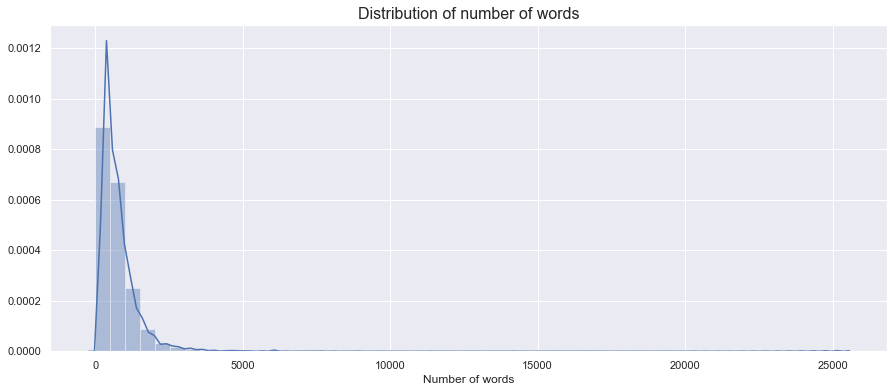

In [315]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax);

In [316]:
print("There are {} documents with over 1500 words.".format(sum(document_lengths > 1500)))

There are 751 documents with over 1500 words.


In [320]:
print("There are {} documents with under 20 words.".format(sum(document_lengths < 50)))

There are 259 documents with under 20 words.


In [335]:
normalized_docs = document_lengths[(document_lengths <= 1500) & (document_lengths >= 50)]


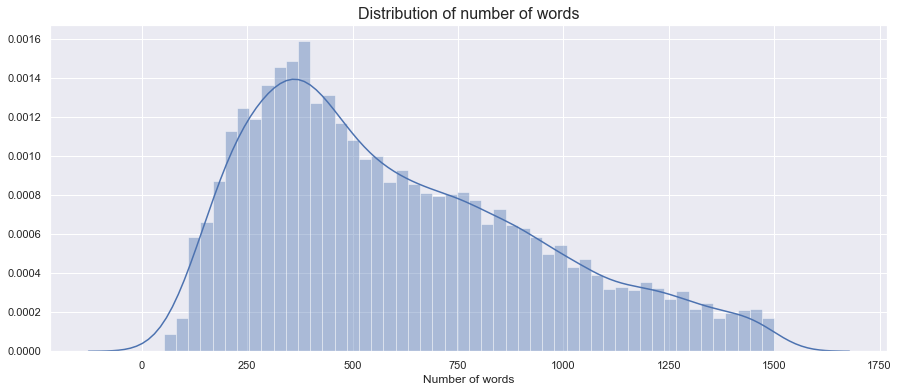

In [336]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(normalized_docs, bins=50, ax=ax);

In [337]:
#to view the docs
df3.Content[document_lengths <= 50].values


array(['This past year produced no shortage of cool tech toys. Whether you re shopping for a loved one or yourself, here are some of this journalist s favorites from 2016. Marc Saltzman Special for  . Follow Marc on Twitter',
       'Global uncertainties The Chinese approach',
       'The author is an associate researcher with the China Institutes of Contemporary International Relations Copy edited by Rebeca Toledo Comments to',
       'China plans to use artificial intelligence AI and unmanned aerial vehicles, or drones, to inspect, repair and preserve the Great Wall. Xinhua News Agency April 26, 2018',
       'A previously unheralded shell company that Google Inc registered in Shanghai a year ago could become a key component in the U.S. search engine s possible reboot in China.',
       'China s annual Spring Festival Gala will make breakthroughs using advanced technologies such as 4K and 5G this year, according to its producer China Media Group on January 31.',
       'World leaders

In [721]:
'''
#df4 =df3[(document_lengths <= 1500) & (document_lengths >= 50)]
from langdetect import detect
l=[]
for doc in df4.Content:
    l.append(detect(doc))
df4['lang']=l
df4=df4[df4['lang']=='en']

#df4.to_csv('jap2.csv', index=False)
'''
#df4=pd.read_csv('jap2.csv', encoding='utf8')
len(df4)

"\n#df4 =df3[(document_lengths <= 1500) & (document_lengths >= 50)]\nfrom langdetect import detect\nl=[]\nfor doc in df4.Content:\n    l.append(detect(doc))\ndf4['lang']=l\ndf4=df4[df4['lang']=='en']\n\n#df4.to_csv('jap2.csv', index=False)\n"

7621

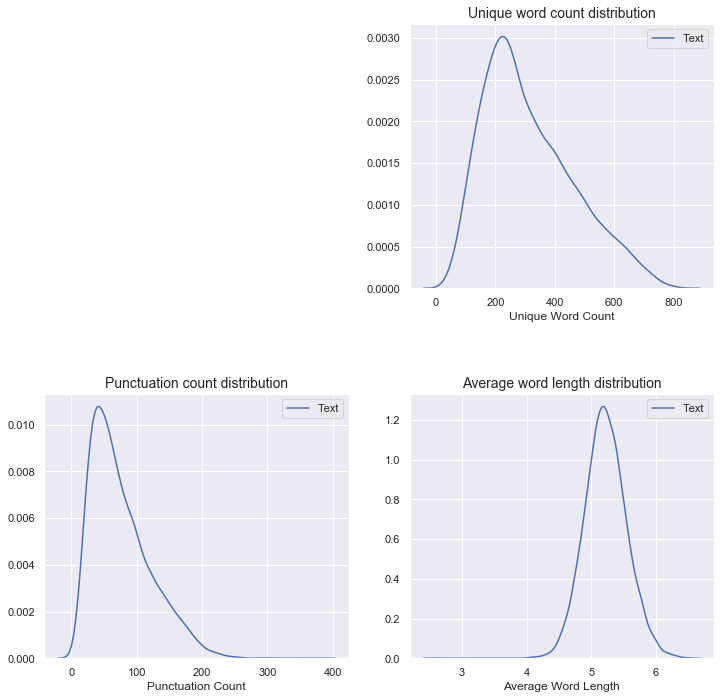

In [431]:
#Unique word count
count_unique_word = df4['Content'].apply(lambda x: len(set(str(x).split())))

#Punctutation count
count_punctuation = df4['Content'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#Average length of the words
mean_word_len = df4['Content'].apply(lambda x : np.mean([len(x) for x in str(x).split()]))

plt.figure(figsize = (12,18))


plt.subplot(322)
g2 = sns.distplot(count_unique_word,
                 hist = False, label = 'Text')
g2.set_title('Unique word count distribution', fontsize = 14)
g2.set(xlabel='Unique Word Count')

plt.subplot(323)
g3 = sns.distplot(count_punctuation,
                 hist = False, label = 'Text')
g3.set_title('Punctuation count distribution', fontsize =14)
g3.set(xlabel='Punctuation Count')

plt.subplot(324)
g4 = sns.distplot(mean_word_len,
                 hist = False, label = 'Text')
g4.set_title('Average word length distribution', fontsize = 14)
g4.set(xlabel = 'Average Word Length')

plt.subplots_adjust(wspace = 0.2, hspace = 0.4, top = 0.9)
plt.legend()
plt.show();



In [565]:
import textacy; from textacy import preprocessing, ke, vsm, tm, text_utils, Corpus, doc
import spacy; from spacy.lang.en import English
from spacy_langdetect import LanguageDetector
from googletrans import Translator

import en_core_web_lg
nlp = en_core_web_lg.load()

In [27]:

df4=pd.read_csv('jap2.csv', encoding='utf8')
'''

ds = df4.to_dict('records')
text_stream, metadata_stream = textacy.io.split_record_fields(ds, 'Content')
list_a =list(text_stream)
list_b = list(metadata_stream)
records = list(zip(list_a, list_b))
corpus = textacy.Corpus(nlp, data=records)

'''
df4.country.value_counts()

"\n\nds = df4.to_dict('records')\ntext_stream, metadata_stream = textacy.io.split_record_fields(ds, 'Content')\nlist_a =list(text_stream)\nlist_b = list(metadata_stream)\nrecords = list(zip(list_a, list_b))\ncorpus = textacy.Corpus(nlp, data=records)\n\n"

uk      958
kore    938
cn      928
ind     909
us      862
jap     817
tr      789
taiw    566
rus     559
ger     295
Name: country, dtype: int64

In [729]:
#corpus.save("corplrg.bin.gz")

In [730]:
######START HERE~~~~~

#corpilo = textacy.Corpus.load(nlp, "corplrg.bin.gz")

In [653]:
co=corpilo
        
co.remove(lambda doc: textacy.spacier.doc_extensions.get_lang(doc) =='en')
co

Corpus(0 docs, 0 tokens)

In [731]:
corpilo.n_docs, corpilo.n_sents, corpilo.n_tokens
word_counts = corpilo.word_counts(as_strings=True)
sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:100]


(7621, 220599, 5143785)

[('-PRON-', 165473),
 ('s', 47251),
 ('AI', 16812),
 ('company', 16292),
 ('technology', 15815),
 ('year', 13417),
 ('use', 12867),
 ('new', 11762),
 ('China', 11039),
 ('intelligence', 10096),
 ('artificial', 9574),
 ('people', 8383),
 ('work', 8003),
 ('human', 7808),
 ('system', 7304),
 ('world', 7130),
 ('datum', 7115),
 ('t', 7053),
 ('include', 6801),
 ('time', 6738),
 ('like', 6594),
 ('robot', 6588),
 ('service', 6403),
 ('Google', 6371),
 ('country', 6217),
 ('market', 5716),
 ('industry', 5698),
 ('help', 5564),
 ('business', 5552),
 ('percent', 5321),
 ('develop', 5293),
 ('need', 5260),
 ('come', 5196),
 ('accord', 5069),
 ('research', 4811),
 ('report', 4728),
 ('development', 4706),
 ('government', 4580),
 ('machine', 4558),
 ('billion', 4461),
 ('create', 4437),
 ('chinese', 4433),
 ('million', 4429),
 ('way', 4303),
 ('big', 4106),
 ('user', 4090),
 ('global', 4057),
 ('add', 3955),
 ('future', 3948),
 ('product', 3945),
 ('job', 3930),
 ('plan', 3872),
 ('good', 3820),

[('-PRON-', 165473),
 ('s', 47251),
 ('AI', 16812),
 ('company', 16292),
 ('technology', 15815),
 ('year', 13417),
 ('use', 12867),
 ('new', 11762),
 ('China', 11039),
 ('intelligence', 10096),
 ('artificial', 9574),
 ('people', 8383),
 ('work', 8003),
 ('human', 7808),
 ('system', 7304),
 ('world', 7130),
 ('datum', 7115),
 ('t', 7053),
 ('include', 6801),
 ('time', 6738),
 ('like', 6594),
 ('robot', 6588),
 ('service', 6403),
 ('Google', 6371),
 ('country', 6217),
 ('market', 5716),
 ('industry', 5698),
 ('help', 5564),
 ('business', 5552),
 ('percent', 5321),
 ('develop', 5293),
 ('need', 5260),
 ('come', 5196),
 ('accord', 5069),
 ('research', 4811),
 ('report', 4728),
 ('development', 4706),
 ('government', 4580),
 ('machine', 4558),
 ('billion', 4461),
 ('create', 4437),
 ('chinese', 4433),
 ('million', 4429),
 ('way', 4303),
 ('big', 4106),
 ('user', 4090),
 ('global', 4057),
 ('add', 3955),
 ('future', 3948),
 ('product', 3945),
 ('job', 3930),
 ('plan', 3872),
 ('good', 3820),

[('Boak', 1),
 ('Yilnaz', 1),
 ('Spyce', 1),
 ('Krupa', 1),
 ('Chinatopix', 1),
 ('confiscation', 1),
 ('Thermo', 1),
 ('sequencer', 1),
 ('Kazakhs', 1),
 ('addle', 1),
 ('crowd_pleaser', 1),
 ('cartoon_like', 1),
 ('O.Other', 1),
 ('half_completed', 1),
 ('Tuesday.___Anderson', 1),
 ('Anick', 1),
 ('Jesdanun', 1),
 ('2018.pichai', 1),
 ('Walgreen', 1),
 ('platformwal_mart', 1),
 ('voice_ordering', 1),
 ('cur_123.4', 1),
 ('Prices', 1),
 ('CUR_927.00', 1),
 ('CUR_79.96', 1),
 ('multi_billion_pound', 1),
 ('Swansea', 1),
 ('zero_hours', 1),
 ('Gloucester', 1),
 ('8.75', 1),
 ('.norwich', 1),
 ('Refectory', 1),
 ('disinvest', 1),
 ('figurehead', 1),
 ('church_sponsored', 1),
 ('eton_educate', 1),
 ('CBF', 1),
 ('CCLA', 1),
 ('hardback', 1),
 ('saidd', 1),
 ('Gyngell', 1),
 ('hypocrite', 1),
 ('inventory_handling', 1),
 ('acrylic', 1),
 ('Academics', 1),
 ('Amitai', 1),
 ('locatable', 1),
 ('unassiste', 1),
 ('HAIFA', 1),
 ('palestinian_israeli', 1),
 ('Dusan', 1),
 ('Vranic', 1),
 ('40_p

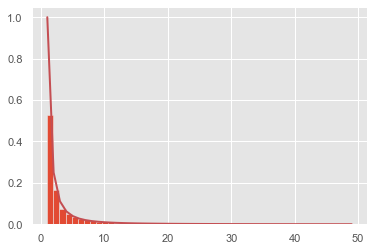

In [725]:
#hapax
sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:100]#most freq
sorted(word_counts.items(), key=lambda x: x[1], reverse=False)[:1000]#least freq
hap = list({k:v for k,v in word_counts.items() if   v==1})#hapax list


#zipf's distribution
from operator import itemgetter
from scipy import special
#convert value of frequency to numpy array
s = np.fromiter(word_counts.values(), dtype=float)
#Calculate zipf and plot the data
a = 2. #  distribution parameter
count, bins, ignored = plt.hist(s[s<50], 50, density=True)
x = np.arange(1., 50.)
y = x**(-a) / special.zetac(a)
plt.plot(x, y/max(y), linewidth=2, color='r')
plt.show()


In [726]:
for i in corpilo:
   ts= textacy.TextStats(i)
   i._.meta.update(ts.basic_counts)
   i._.meta.update(ts.readability_stats)
   xx= (value for (key,value) in i._.meta.items() if key in 'n_unique_words')
   yy = (value for (key,value) in i._.meta.items() if key in 'n_words')
   ttr= [x/y for x,y in zip(xx,yy)]
   i._.meta.update({'type/token': float(''.join(map(str,ttr)))})   
   ww= i._.to_bag_of_terms(ngrams=1, named_entities=False,  weighting=u'count', as_strings=True)
   vv = [len({k:v for k,v in ww.items() if   v==1})]
   yy =  [value for (key,value) in i._.meta.items() if key in 'n_words']
   hpr= [x/y for x,y in zip(vv,yy)]
   i._.meta.update({'hapax/word': float(''.join(map(str,hpr)))})
   xx= (value for (key,value) in i._.meta.items() if key in 'n_sents')
   yy = (value for (key,value) in i._.meta.items() if key in 'n_words')
   sw= [y/x for x,y in zip(xx,yy)]
   i._.meta.update({'word/sentence': float(''.join(map(str,sw)))})
   xx= (value for (key,value) in i._.meta.items() if key in 'n_long_words')
   yy = (value for (key,value) in i._.meta.items() if key in 'n_words')
   lw= [x/y for x,y in zip(xx,yy)]
   i._.meta.update({'longword/word': float(''.join(map(str,lw)))})

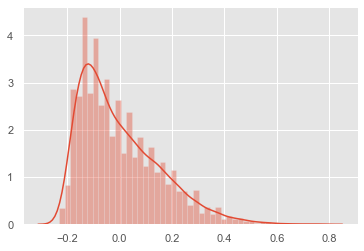

In [732]:
#documenmt length
cc=[]
for i in corpilo:
   xx= [value for (key,value) in i._.meta.items() if key in 'n_sents']
   cc.append(xx)
xx = pd.Series([item for sublist in cc for item in sublist])
df_norm = (xx - xx.mean()) / (xx.max() - xx.min())
sns.distplot( df_norm.values)

In [546]:
lng=list(corpilo.get(lambda doc: doc._.meta["n_sents"] >100))#to get the number of sentences above /below a thresho;ld
len(lng)

14

In [547]:
shrt=list(corpilo.get(lambda doc: doc._.meta["n_sents"] < 10))#to get the number of sentences above /below a thresho;ld
len(shrt)

666

In [548]:
mid = list(corpilo.get(lambda doc: doc._.meta['n_sents'] < 100 and doc._.meta['n_sents'] > 10))

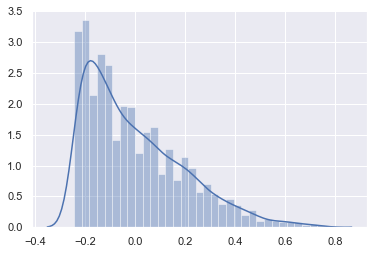

In [549]:
sn=[]
for doc in mid:
   xx= [value for (key,value) in doc._.meta.items() if key in 'n_sents']
   sn.append(xx)   
xx = pd.Series([item for sublist in sn for item in sublist])
df_norm = (xx - xx.mean()) / (xx.max() - xx.min())
sns.distplot( df_norm.values)

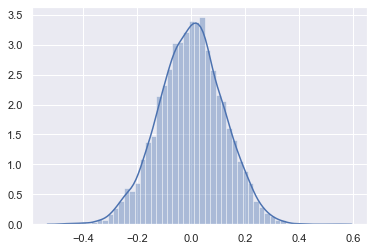

In [424]:
fre=[]
for doc in mid:
   xx= [value for (key,value) in doc._.meta.items() if key in 'flesch_reading_ease']
   fre.append(xx)  

xx =  pd.Series([item for sublist in fre for item in sublist])
df_norm = (xx - xx.mean()) / (xx.max() - xx.min())
sns.distplot( df_norm.values)   


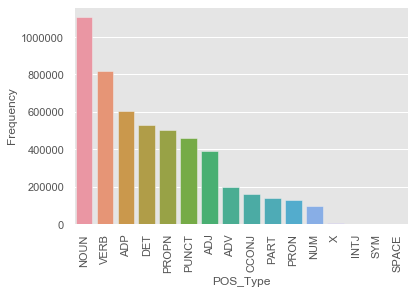

In [733]:
from textacy import spacier

#####count pos tags
pt=[item for sublist in (spacier.doc_extensions.to_tagged_text(doc) for doc in corpilo)  for item in sublist]
post= [item for sublist in pt for item in sublist]
pos_frame = pd.DataFrame(post, 
                            columns=['POS_Name', 'POS_Type']) 
top_POS = (pos_frame.groupby(by=['POS_Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
#top_POS.plot.bar(x='POS Type', y='Frequency', rot=90)
g = sns.barplot(x='POS_Type', y='Frequency', data = top_POS)   
#g.set_xticklabels(rotation=90)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

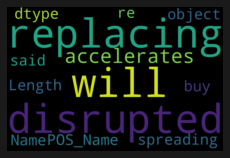

In [422]:
posta=pos_frame[pos_frame['POS_Type']=='VERB']
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
txt = posta.POS_Name.str.replace(r'[^\w\s]+', ' ')
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',max_words=500,
    stopwords = STOPWORDS).generate(str(txt))
fig = plt.figure(
    figsize = (3, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();


In [734]:
from textacy import spacier
terms = [[i for i in li] for li in [spacier.doc_extensions.to_terms_list(doc, ngrams=(1), entities=True, as_strings=True,\
                                                                        include_pos=('NOUN', 'PROPN', 'ADJ'), filter_nums=True) for doc in corpilo]]


In [665]:
bot = [[i for i in li] for li in [spacier.doc_extensions.to_terms_list(doc, ngrams=(1), entities=True, as_strings=True,\
                                                                        include_pos=('NOUN', 'PROPN', 'ADJ'), filter_nums=True) for doc in corpilo]]

In [551]:
lems= [[(w.lemma_) for w in doc if  not w.is_stop and not w.is_punct and not w.like_num ] for doc in corpilo]

In [902]:
tr_vector=[[i for i in li] for li in [ke.textrank(doc, normalize='lemma', include_pos=('NOUN', 'PROPN', 'ADJ'), window_size=2, edge_weighting="binary", position_bias=False,\
                                                       topn=100) for doc in corpilo]]#positional ranking

In [ ]:
prnk=[[i[0] for i in li] for li in [ke.textrank(doc, normalize='lemma', include_pos=('NOUN', 'PROPN', 'ADJ'), window_size=10, edge_weighting='count', position_bias=True,\
                                                       topn=100) for doc in corpilo]]#positional ranking

In [738]:
sr=[[i[0] for i in li] for li in [ke.textrank(doc, normalize='lemma', include_pos=('NOUN', 'PROPN', 'ADJ'), window_size=10, edge_weighting='count', position_bias=True,\
                                                       topn=100) for doc in corpilo]]#positional ranking

7621

In [741]:
yak_vector=[[i for i in li] for li in [ke.yake(doc, normalize='lemma', ngrams=(1, 2, 3), include_pos=('NOUN', 'PROPN', 'ADJ'),\
                                           window_size=10, topn=300) for doc in corpilo]]
#yak_vector is for 300 kws. yak 100 is the other, nio vector but as bot

In [526]:
scak=[[i[0] for i in li] for li in [ke.scake(doc, normalize='lemma', include_pos=('NOUN', 'PROPN', 'ADJ'), topn=100) for doc in corpilo]]
## Finds general specific topics, might be useful for larger MDS visualization, check the literature

In [883]:
sgrnk=[[i[0] for i in li] for li in [ke.sgrank(doc, normalize='lemma', ngrams=(1, 2, 3, 4, 5, 6), include_pos=('NOUN', 'PROPN', 'ADJ'), window_size=1500, topn=300, idf=None) for doc in corpilo]]
#seems to be th ebst, but low coherence

In [13]:
'''

import pickle
with open('yak_vector', 'wb') as fp:
    pickle.dump(yak_vector, fp)
'''


NameError: name 'yak_vector' is not defined

In [3]:
####START HERE######
import pickle
with open ('yak_vector', 'rb') as fp:# posrank terms
    yak = pickle.load(fp)#prnk yakws100 scak yak10 sr bot yak10

We are therefore concerned to read the nonchalant
claim “... that only function words are discarded from the analysis in Alceste.” (BWB, :597).
Depending on the material to be analysed, this can make the difference between correct
retrieval of significant content and actively misleading results.

In [6]:
'''1. This part cleans trims the dictionary from extreme values and looks again'''
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.extend(['people','agency', 'Agency', 'subject', 'p.m.', 'early', 'time', 'year', 'use', 'not', 'would', 'say', 'could',  'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see',
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right',
                   'line', 'even', 'also', 'may', 'take', 'come' ,  'able',  'area','case',  'company','country',
                   'day','decade','example','future','head','high','January','lot','month','need','number','number',
                   'people','percent','place','result','thing','time','Tuesday','use','way','week',   'world','year',
                   'artificial intelligence', 'artificial intelligence AI', 'A.I.','ai' ,'April', 'August', 'century',
                   'date', 'December', 'difficult', 'dozen', 'February','form','great','history','hour','hundred',
                  'July','June','kilometer','kind','late','long','March','million','million','minute',
                   'November','October','part','past','point','previous', 'real','recent',
                   'role','September','term','thousand','today', 'January', 'May', 'Monday', 'Wednesday',
                  'Thursday', 'Friday', 'Saturday', 'Sunday', 'ush','ush(function', 'IST', 'ist' ])

from spacy.lang.en.stop_words import STOP_WORDS
stop_words =  set(stop_words).union(set(STOP_WORDS))
 
lms0 =[[i[0] for i in li] for li in yak]
lms = [[word.lower() for word in doc if word not in stop_words] for doc in lms0]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


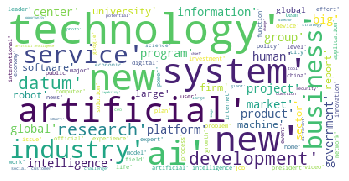

In [7]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(lms))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [8]:
docs = [" ".join(x) for x in lms]

In [9]:
#sklearn for nmf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

abo=.95# for terms = .90, prnk. yak =.95 yak300 .95
belo=20# for tersm =25   yak =15, tr, prnk,sgrnk =10 yak 300 25

vectorizer = TfidfVectorizer(max_df=abo, min_df = belo, stop_words = stop_words)
doc_term_matrix = vectorizer.fit_transform(docs)# corpus
print( "Created %d X %d document-term matrix" % (doc_term_matrix.shape[0], doc_term_matrix.shape[1]) )
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

/usr/local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['april', 'artificial', 'august', 'december', 'february', 'friday', 'function', 'intelligence', 'january', 'july', 'june', 'march', 'monday', 'november', 'october', 'saturday', 'september', 'sunday', 'thursday', 'tuesday', 'wednesday'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Created 7621 X 5633 document-term matrix
Vocabulary has 5633 distinct terms


In [10]:
# top 20 terms,
import operator
def rank_terms( doc_term_matrix, terms ):
    # get the sums over each column
    sums = doc_term_matrix.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

ranking = rank_terms( doc_term_matrix, terms )
for i, pair in enumerate( ranking[0:20] ):
    print( "%02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )

01. technology (219.51)
02. new (211.40)
03. research (160.09)
04. intelligence (153.36)
05. business (149.48)
06. system (143.76)
07. human (141.36)
08. chinese (140.27)
09. service (137.10)
10. global (133.20)
11. industry (129.75)
12. artificial (125.31)
13. president (123.55)
14. datum (122.58)
15. market (122.43)
16. news (114.41)
17. development (112.76)
18. robot (112.67)
19. big (109.72)
20. tech (109.63)


In [11]:
kmin, kmax, kstp = 5, 100,5
    
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin, kmax+1, kstp):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( doc_term_matrix )
    H = model.components_    
    # store for later
    topic_models.append((k,W,H))

Applying NMF for k=5 ...
Applying NMF for k=10 ...
Applying NMF for k=15 ...
Applying NMF for k=20 ...
Applying NMF for k=25 ...
Applying NMF for k=30 ...
Applying NMF for k=35 ...
Applying NMF for k=40 ...
Applying NMF for k=45 ...
Applying NMF for k=50 ...
Applying NMF for k=55 ...
Applying NMF for k=60 ...
Applying NMF for k=65 ...
Applying NMF for k=70 ...
Applying NMF for k=75 ...
Applying NMF for k=80 ...
Applying NMF for k=85 ...
Applying NMF for k=90 ...
Applying NMF for k=95 ...
Applying NMF for k=100 ...


In [12]:
import re
class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append(tok)
            yield tokens

import gensim
docgen = TokenGenerator(docs, stop_words)
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, sg=1)
print("Model has %d terms" % len(w2v_model.wv.vocab))

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Model has 24425 terms


In [13]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

import numpy as np
def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index,:])[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(all_terms[term_index])
    return top_terms

In [14]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor(terms, H, topic_index, 10))
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append( calculate_coherence(w2v_model, term_rankings))
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys


K=05: Coherence=0.3688
K=10: Coherence=0.3818
K=15: Coherence=0.4245
K=20: Coherence=0.4536
K=25: Coherence=0.4574
K=30: Coherence=0.4596
K=35: Coherence=0.4500
K=40: Coherence=0.4572
K=45: Coherence=0.4579
K=50: Coherence=0.4552
K=55: Coherence=0.4694
K=60: Coherence=0.4664
K=65: Coherence=0.4722
K=70: Coherence=0.4757
K=75: Coherence=0.4824
K=80: Coherence=0.4778
K=85: Coherence=0.4787
K=90: Coherence=0.4756
K=95: Coherence=0.4846
K=100: Coherence=0.4804


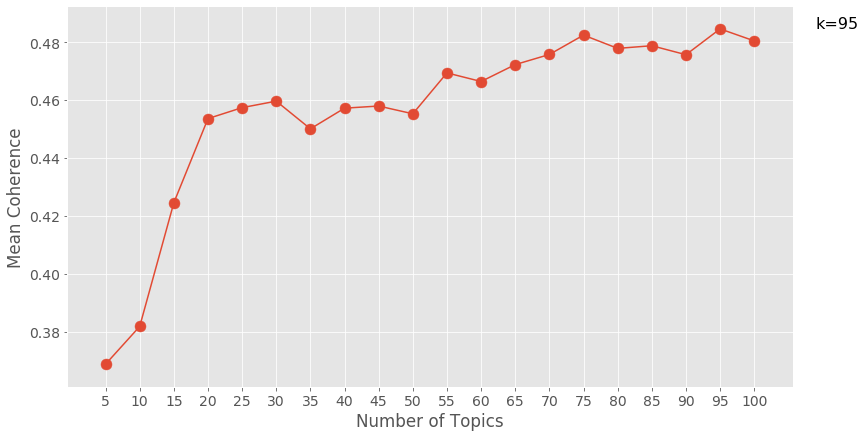

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show();

In [16]:
k = 70
intrv=5
# get the model that we generated earlier.
W = topic_models[int(k/intrv)][1]
H = topic_models[int(k/intrv)][2]
for topic_index in range(k):
    descriptor = get_descriptor(terms, H, topic_index, 10)
    str_descriptor = ", ".join(descriptor)
    print("Topic %02d: %s" % (topic_index+1, str_descriptor))

Topic 01: economic, growth, economy, development, policy, cooperation, forum, new, reform, global
Topic 02: trade, tariff, export, secretary, free, war, bilateral, import, foreign, trading
Topic 03: human, computer, science, scientist, researcher, university, system, professor, brain, machine
Topic 04: assistant, speaker, voice, amazon, echo, home, alexa, device, personal, siri
Topic 05: lee, alphago, champion, se_dol, deepmind, program, match, player, demis, board
Topic 06: shanghai, international, china, conference, exhibition, innovation, industry, development, municipal, city
Topic 07: defense, military, air, force, aircraft, drone, missile, unmanned, fighter, pentagon
Topic 08: keyword, wire, copyright, business, source, america, contact, north, industry, services
Topic 09: car, vehicle, autonomous, driving, self_driving, motor, driver, electric, road, driverless
Topic 10: energy, renewable, power, wind, solar, electricity, gas, plant, emission, geothermal
Topic 11: chinese, china

In [19]:
lms2=[]
for dc in docs:
    lms2.append(dc.split())

import pickle
with open('lms2', 'wb') as fp:
    pickle.dump(lms2, fp)

In [20]:
docs = [" ".join(x) for x in lms2]

In [23]:
import pandas as pd

def findBet(sw, ew, text):#Finds the text between two strings
    regex =r"(?=" +sw+ ").*?(?<="+ew+")"
    w=text.str.findall(regex)
    txt=[i for i in w if type(i) is not float]
    return [item for sublist in txt for item in sublist]

sw =r'\Waposve\W'#aposs, apos, apost, uk, aposre, aposve  latest india news central
ew=r'\W'
do=pd.DataFrame(docs)
findBet(sw, ew, do.iloc[0:,0])

['&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&',
 '&']

In [27]:
from textacy import text_utils
def kwic(kw, wd, dataframe):#bunu ew sw ve ew icerecek sekilde duzelt
    for news in dataframe:
        w = text_utils.KWIC(news, kw, window_width=wd) 
        
kwic("\Waposs\W", 50, docs)

em algorithm user incredible prize confidence limb &aposs  freedom base panel smart big sue ion professor say
oyal highness artifical intelligent advanced world &aposs  nobel prize apostalk&apos response stair dr datum 
esterday exciting natural clinician society sector &aposs  winner quick aposnext exceptional team selection a
assionate impact approach support true positive uk &aposs  variety discomfort model uk technology award winne
obotic limb ankle function system engineering limb &aposs  central incredible innovation innovation prize rob
ncredible innovation innovation prize robotic limb &aposs  calibration process smart robotic smart algorithm 
art algorithm engineering sector technology sector &aposs  hip problem exciting engineering selection process
irector comprehensive award continuous dialog limb &aposs  creator manufacturing base advanced artifical limb
approach positive impact true role role model limb &aposs  creator blatchford prosthetic limb wearer incredib
ble intell

In [28]:
def deleteBetween(startWord, endWord, text):
    regex = startWord + "(.*)" + endWord
    for j in range(len(text)):
            text[j] = re.sub(regex,'',text[j], flags=re.DOTALL)
    return text 
deleteBetween(sw, ew, docs)

['brookings institution ap photo u.s. report brookings institution report job automation work new intelligence robot americans artificial new brookings quarter file technology u.s. job amazon machine muro ap photo mary worker york cortes task change photo brookings report current exposure states restaurant united united states washington island economic hotel industry workforce shift education altaffer new york walmart aren t staten island ap photo nam likely downturn driver short_haul business clerical borough recession risk economist service center fulfillment food manufacturing level floor store robotic assistant datum mary altaffer pod production mark ap economics ap photo charles ap photo david mark muro file file photo mary altaffer photo matt huh y. chicago rourke belt rust indiana krupa kentucky harrisburg writer josh boak j. phillip boston toronto houston giant matias university marty supercenter amnesty quarterback artur yilnaz bossa nova spyce robot aren y. huh nam y. photo 

In [31]:
from textacy import preprocessing, ke, vsm, tm, text_utils, Corpus, doc
from sklearn.decomposition import NMF, LatentDirichletAllocation,  TruncatedSVD

abo=.95# for terms = .90, prnk. yak =.95 yak300 .95
belo=25# for tersm =25   yak =15, tr, prnk,sgrnk =10 yak 300 25

vectorizer = vsm.Vectorizer(tf_type="linear", apply_idf=True, idf_type="smooth", norm="l2",\
                                min_df=belo, max_df=abo)#tfidf
doc_term_matrix =vectorizer.fit_transform(lms2)#lms

ntop=70
nmfmodel = NMF( init="nndsvd", n_components=ntop ) 
doc_topic_matrix = nmfmodel.fit_transform( doc_term_matrix )#
H = nmfmodel.components_ # term weights relative to each of the k topics.
#to which topic is related the word
terms = vectorizer.terms_list#vectorizer.get_feature_names()

import numpy as np
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    topic_terms = []
    for term_index in top_indices[0:top]:
        topic_terms.append( terms[term_index] )
    return topic_terms

nmftopics = []#descriptors is the other name
for topic_index in range(ntop):#10 is the no of topic words, as with the other models=10
    nmftopics.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( nmftopics[topic_index] )

In [34]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LsiModel,  HdpModel, CoherenceModel

dictionary = Dictionary(documents=lms2)
dictionary.filter_extremes(no_above=abo, no_below=belo)
dictionary.compactify()  # Reindexes the remaining words after filtering

CoherenceModel(topics=nmftopics, texts=lms2, dictionary=dictionary, window_size=200).get_coherence()

0.7079683139084787

In [35]:
for topic_index in range(ntop):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: datum, data, big, information, privacy, protection, analysis, industry, management, personal
Topic 02: economic, growth, economy, development, cooperation, policy, forum, global, new, reform
Topic 03: neural, learning, network, human, deep, computer, brain, machine, system, researcher
Topic 04: mark, facebook, ceo, zuckerberg, photo, francisco, san, ap, images, getty
Topic 05: business, service, firm, company, management, customer, provider, software, solution, technology
Topic 06: samsung, electronics, galaxy, bixby, s8, lee, smartphone, koh, r&d, note
Topic 07: car, vehicle, autonomous, self_driving, driving, driver, road, driverless, safety, traffic
Topic 08: keyword, wire, copyright, source, business, america, contact, north, industry, services
Topic 09: motor, toyota, corp., auto, hyundai, honda, automaker, motors, ford, electric
Topic 10: energy, renewable, power, wind, solar, electricity, gas, plant, emission, geothermal
Topic 11: chinese, china, beijing, li, baidu, in

In [36]:
W= doc_topic_matrix
def get_top_snippets( all_snippets, W, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

In [37]:
df_document_topic = pd.DataFrame(W)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

dominant_topic_in_each_doc = df_document_topic.groupby('dominant_topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

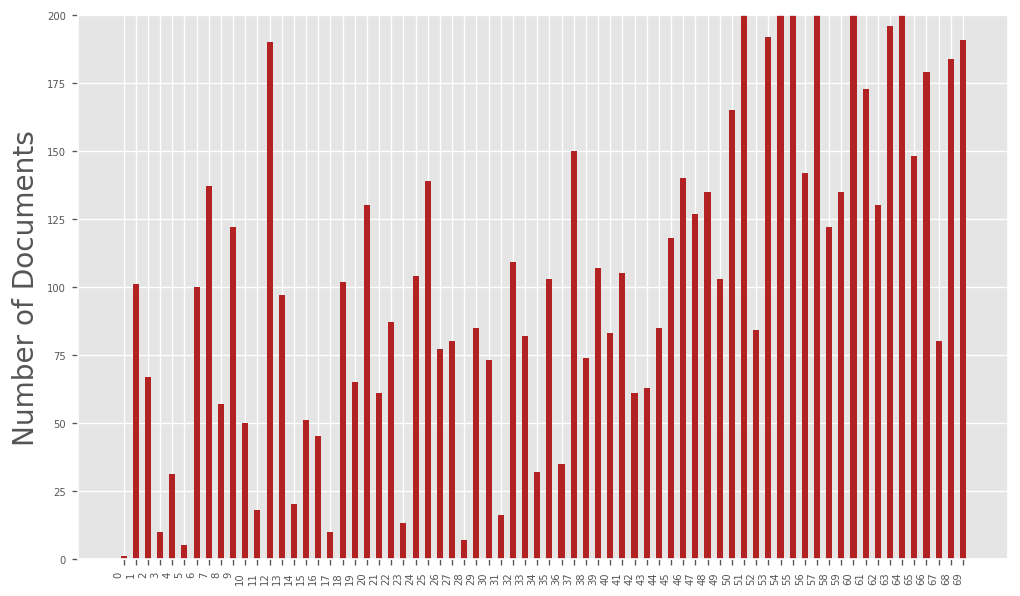

In [38]:
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=120)
ax1.bar(x='dominant_topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.dominant_topic.unique().__len__()))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 200)
ax1.tick_params(axis='both', which='major', labelsize=6, pad=4)
plt.xticks(rotation=90, ha='right')
plt.show();

In [39]:
def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

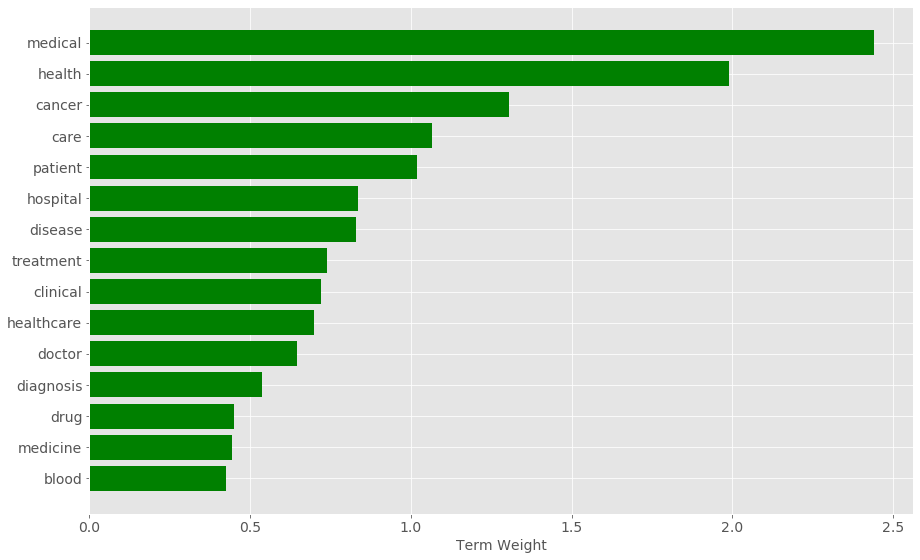

In [40]:
#topic no 8, 15 words
tp=12
plot_top_term_weights( terms, H, tp, 15 )

In [41]:
df4=pd.read_csv('jap2.csv', encoding='utf8')

In [42]:
sz= 10
# how many to be lists
tx=df4.Title#text
topic_snippets = get_top_snippets( tx, W, tp, sz )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. IBM's Watson to be used at Korean hospital 
02.  Tech giants tap AI healthcare market 
03. AI, robots to lead future medical industry
04. What New Delhi’s free clinics can teach America about fixing its broken health care system
05. AI defeats top doctors in competition
06. IBM Watson shows high concordance with physician recommendations: hospital
07. Medical tech firm to promote AI diagnostic system in hospitals
08. Korea forms new regulatory guidelines for AI, big data-based medical devices
09. ‘Beyond products, end-to-end solutions key to success in medtech business’: Medtronic VP
10. AI set to revolutionize healthcare industry in China


In [43]:
tx=lms2#text
topic_snippets = get_top_snippets( tx, W, tp, sz )
for i, snippet in enumerate([item[0:5] for item in topic_snippets]):
    print("%02d. %s" % ( (i+1), snippet ) )

01. ['watson', 'ibm', 'manager', 'jeffrey', 'rhoda']
02. ['guangdong', 'province', 'ai', 'china', 'medical']
03. ['watson', 'medical', 'health', 'selvy', 'kimes']
04. ['kaur', 'medical', 'care', 'test', 'slate']
05. ['ai', 'world', 'cup', 'hospital', 'china']
06. ['watson', 'cancer', 'patient', 'oncology', 'ibm']
07. ['medical', 'technology', 'co', 'cancer', 'tumor']
08. ['medical', 'device', 'product', 'ministry', 'big']
09. ['medtronic', 'medical', 'device', 'kimes', 'knappe']
10. ['li', 'beijing', 'china', 'koboro', 'beijing']


In [44]:
from gensim.summarization import summarize, keywords

sz= 10# how many to be lists
tx=df4.Content#text
topic_snippets = get_top_snippets(tx, W, tp, sz)
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), summarize(snippet, ratio=.1)))

01. IBM Korea General Manager Jeffrey Rhoda, left, shakes hands with Gachon University Gil Medical Center Director Lee Gun after signing an agreement at Lotte Hotel in central Seoul, Thursday, to introduce the Watson artificial intelligence system for cancer treatment.
Courtesy of IBM KoreaAI system to support doctors as advisorBy Yoon Sung_wonIBM said Thursday its artificial intelligence AI system Watson will be used for cancer treatment at Gachon University Gil Medical Center in Korea for the first time.
02. Photo VCGBefore 2017, gastroenterologist Cheng Chunsheng had to inspect over 1,000 gastroscopy pictures to search for possible esophageal cancer symptoms, a cancer which appears in the food pipe.However, this painstaking process has no longer been needed since the People s Hospital of Nanshan District in Shenzhen, South China s Guangdong Province where Cheng works introduced Tencent AIMIS, an artificial intelligence AI medical imaging software released in August 2017.
03. Medical

In [45]:
top_labels = {0: 'AICore', 1:'TradeTalksExc', 2:'Smartphn', 3:'AIFuture', 4:'ChExc',
             5: 'AlphaGovsSedol', 6: 'AV', 7: 'TaiwExc', 8: 'Games', 9: 'AIFilms',
             10: 'RenewEnerg', 11 :'JpExc', 12: 'JapAI' , 13: 'SmartCity', 14: 'JapExc',
            15: 'AIMedical', 16: 'AIPlatforms', 17 :'HealthCare', 18: 'Defense' , 19 :'TrumpExc', 20: 'Hawking',
             21 :'AIAssist', 22 :'Robotic', 23: 'Exc0', 24: 'R&D', 25: 'TRExc',
             26 :'ChExc', 27: 'SFExc', 28: 'FinTech', 29: 'ConfExc', 30 : 'Exc2', 31: 'CybSec ', 32: 'HomeApplian',
             33: 'AILang' , 34 :'Invest', 35: 'GoogleCEO', 36: 'Innovat', 37: 'FacRec' , 38: 'KillerRob', 
             39: 'AutomJobs', 40 : 'MuskWarns', 41 : 'Novelties', 42 : 'CloudComp', 43 :'Conflict' , 44 :'EUHiTec' , 
              45: 'IntProp',46: 'Excl', 47 : 'Chips', 48: 'Exc3', 49: 'Zuckerberg', 50 :'Ind4.0',
             51: 'Retail', 52: 'RussDef', 53: 'SilVal', 54: 'SocMedRisk' , 55 :'Educ', 56: 'CHvsUS' ,
             57: 'Compan', 58: 'Exc4', 59: 'exc5', 60:'DigTrans' , 61: 'AITech', 62:'Space',
             63: 'TechGiants', 64:'ChRise', 65:'SexDoll', 66: 'exc6', 67: 'Innov', 68:'VoiceAsst',
             69 :'UnivRsrc'}

In [46]:
arr = pd.DataFrame(W)
arr = arr.fillna(0)# topic weights
#cols = [1, 4,  7, 12, 14, 19,  23,25, 26, 27, 29, 30, 46, 48, 58, 59, 66 ]
arr.columns = list(top_labels.values())

cols=['TradeTalksExc',  'ChExc', 'TaiwExc', 'JpExc', 'JapExc', 'JapAI', 'TrumpExc', 'Exc0', 'TRExc', 'ChExc',  'SFExc', 'ConfExc',  
'Exc2', 'Excl', 'Exc3', 'Exc4', 'exc5', 'exc6', 'AIAssist']
#arr.drop(arr.columns[cols],axis=1,inplace=True)

arr.drop(cols, axis=1, inplace=True)  

doc_top_mat=arr.values
_lda_keys = list(np.argmax(doc_top_mat, axis=1))#topic numbers
num_example = len(doc_top_mat)
topic_summaries= arr.columns

#DTM['country'] = df4['country']
#DTM.to_csv('Doc100TopMaT.csv', index=False)

In [47]:
narr =arr
narr['War'] = narr[['KillerRob', 'RussDef', 'Defense']].mean(axis=1)
narr['Health'] = narr[['AIMedical', 'HealthCare']].mean(axis=1)
#narr['Research'] = narr[['UnivRsrc', 'R&D']].mean(axis=1)
narr['Game'] = narr[['AlphaGovsSedol', 'Games']].mean(axis=1)
narr['AIEmerging'] = narr[['SilVal', 'Innov', 'Novelties']].mean(axis=1)
narr['HawkingMusk'] = narr[['Hawking', 'MuskWarns']].mean(axis=1)
#narr['AItech'] = narr[['AITech', 'AIPlatforms']].mean(axis=1)
#narr['AICore'] = narr[['AITech', 'AIProspects', 'AIPlatforms', 'JapAI', 'ImitatesBrain']].mean(axis=1)
narr['AIPolicies'] = narr[['EUHiTec', 'ChRise']].mean(axis=1)
narr['TradeWars'] = narr[['Conflict', 'CHvsUS']].mean(axis=1)
#narr['AICore'] = narr[['AIInven', 'ImitatesBrain']].mean(axis=1)
narr['SmartTech'] = narr[['Smartphn', 'HomeApplian', 'VoiceAsst','AITech', 'AIPlatforms' ]].mean(axis=1)


narr.drop(['KillerRob', 'RussDef', 'Defense', 'AIMedical', 'HealthCare', 'AlphaGovsSedol', 'Games', 
           'SilVal', 'Innov', 'Novelties', 
          'Hawking', 'MuskWarns', 'EUHiTec', 'ChRise','Conflict', 'CHvsUS',
          'Smartphn', 'HomeApplian', 'VoiceAsst','AITech', 'AIPlatforms'], axis=1, inplace=True) 

#'AITech', 'AIProspects', 'AIPlatforms', 'JapAI', 'ImitatesBrain',

In [48]:
arr=narr
doc_top_mat=arr.values
_lda_keys = list(np.argmax(doc_top_mat, axis=1))#topic numbers
num_example = len(doc_top_mat)
topic_summaries= arr.columns

DTM = arr
DTM['country'] = df4['country']
DTM.to_csv('Doc38TopMaT.csv', index=False)

In [49]:
from sklearn.manifold import TSNE
import bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.5, init='pca')
# 70-D -> 2-D
tsne_lda = tsne_model.fit_transform(doc_top_mat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7621 samples in 0.055s...
[t-SNE] Computed neighbors for 7621 samples in 8.900s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7621
[t-SNE] Computed conditional probabilities for sample 2000 / 7621
[t-SNE] Computed conditional probabilities for sample 3000 / 7621
[t-SNE] Computed conditional probabilities for sample 4000 / 7621
[t-SNE] Computed conditional probabilities for sample 5000 / 7621
[t-SNE] Computed conditional probabilities for sample 6000 / 7621
[t-SNE] Computed conditional probabilities for sample 7000 / 7621
[t-SNE] Computed conditional probabilities for sample 7621 / 7621
[t-SNE] Mean sigma: 0.013152
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.609688
[t-SNE] KL divergence after 1000 iterations: 1.696021


In [50]:
from IPython.display import display
import seaborn as sns, matplotlib.pyplot as plt, matplotlib.image as mpimg, base64, io, os,  matplotlib.colors as mcolors
import matplotlib; from matplotlib import ticker
%matplotlib inline
from matplotlib.ticker import FuncFormatter
title = '35 LDA viz'
colormap = np.array([color for name, color in mcolors.XKCD_COLORS.items()])
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool
plot_lda = bp.figure(plot_width=1400, plot_height=1100,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1],
                 color=colormap[_lda_keys][:num_example],
              )

topic_coord = np.empty((np.array(doc_top_mat).shape[1], 2)) * np.nan
for topic_num in _lda_keys:
  if not np.isnan(topic_coord).any():
    break
  topic_coord[topic_num] = tsne_lda[_lda_keys.index(topic_num)]

# plot crucial words
for i in range(np.array(doc_top_mat).shape[1]):
  plot_lda.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

output_file("foo.html")
show(plot_lda);

In [51]:
tp_lbls={k: v for k, v in enumerate(list(topic_summaries))}

In [52]:
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, annotations, LabelSet

words_2d = tsne_lda
df = pd.DataFrame(columns=['x', 'y', 'topic'])
df['x'], df['y'], df['topic'] = words_2d[:,0], words_2d[:,1], _lda_keys
df= df.replace({"topic": tp_lbls})
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="topic", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=1500, plot_height=1500)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True);

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


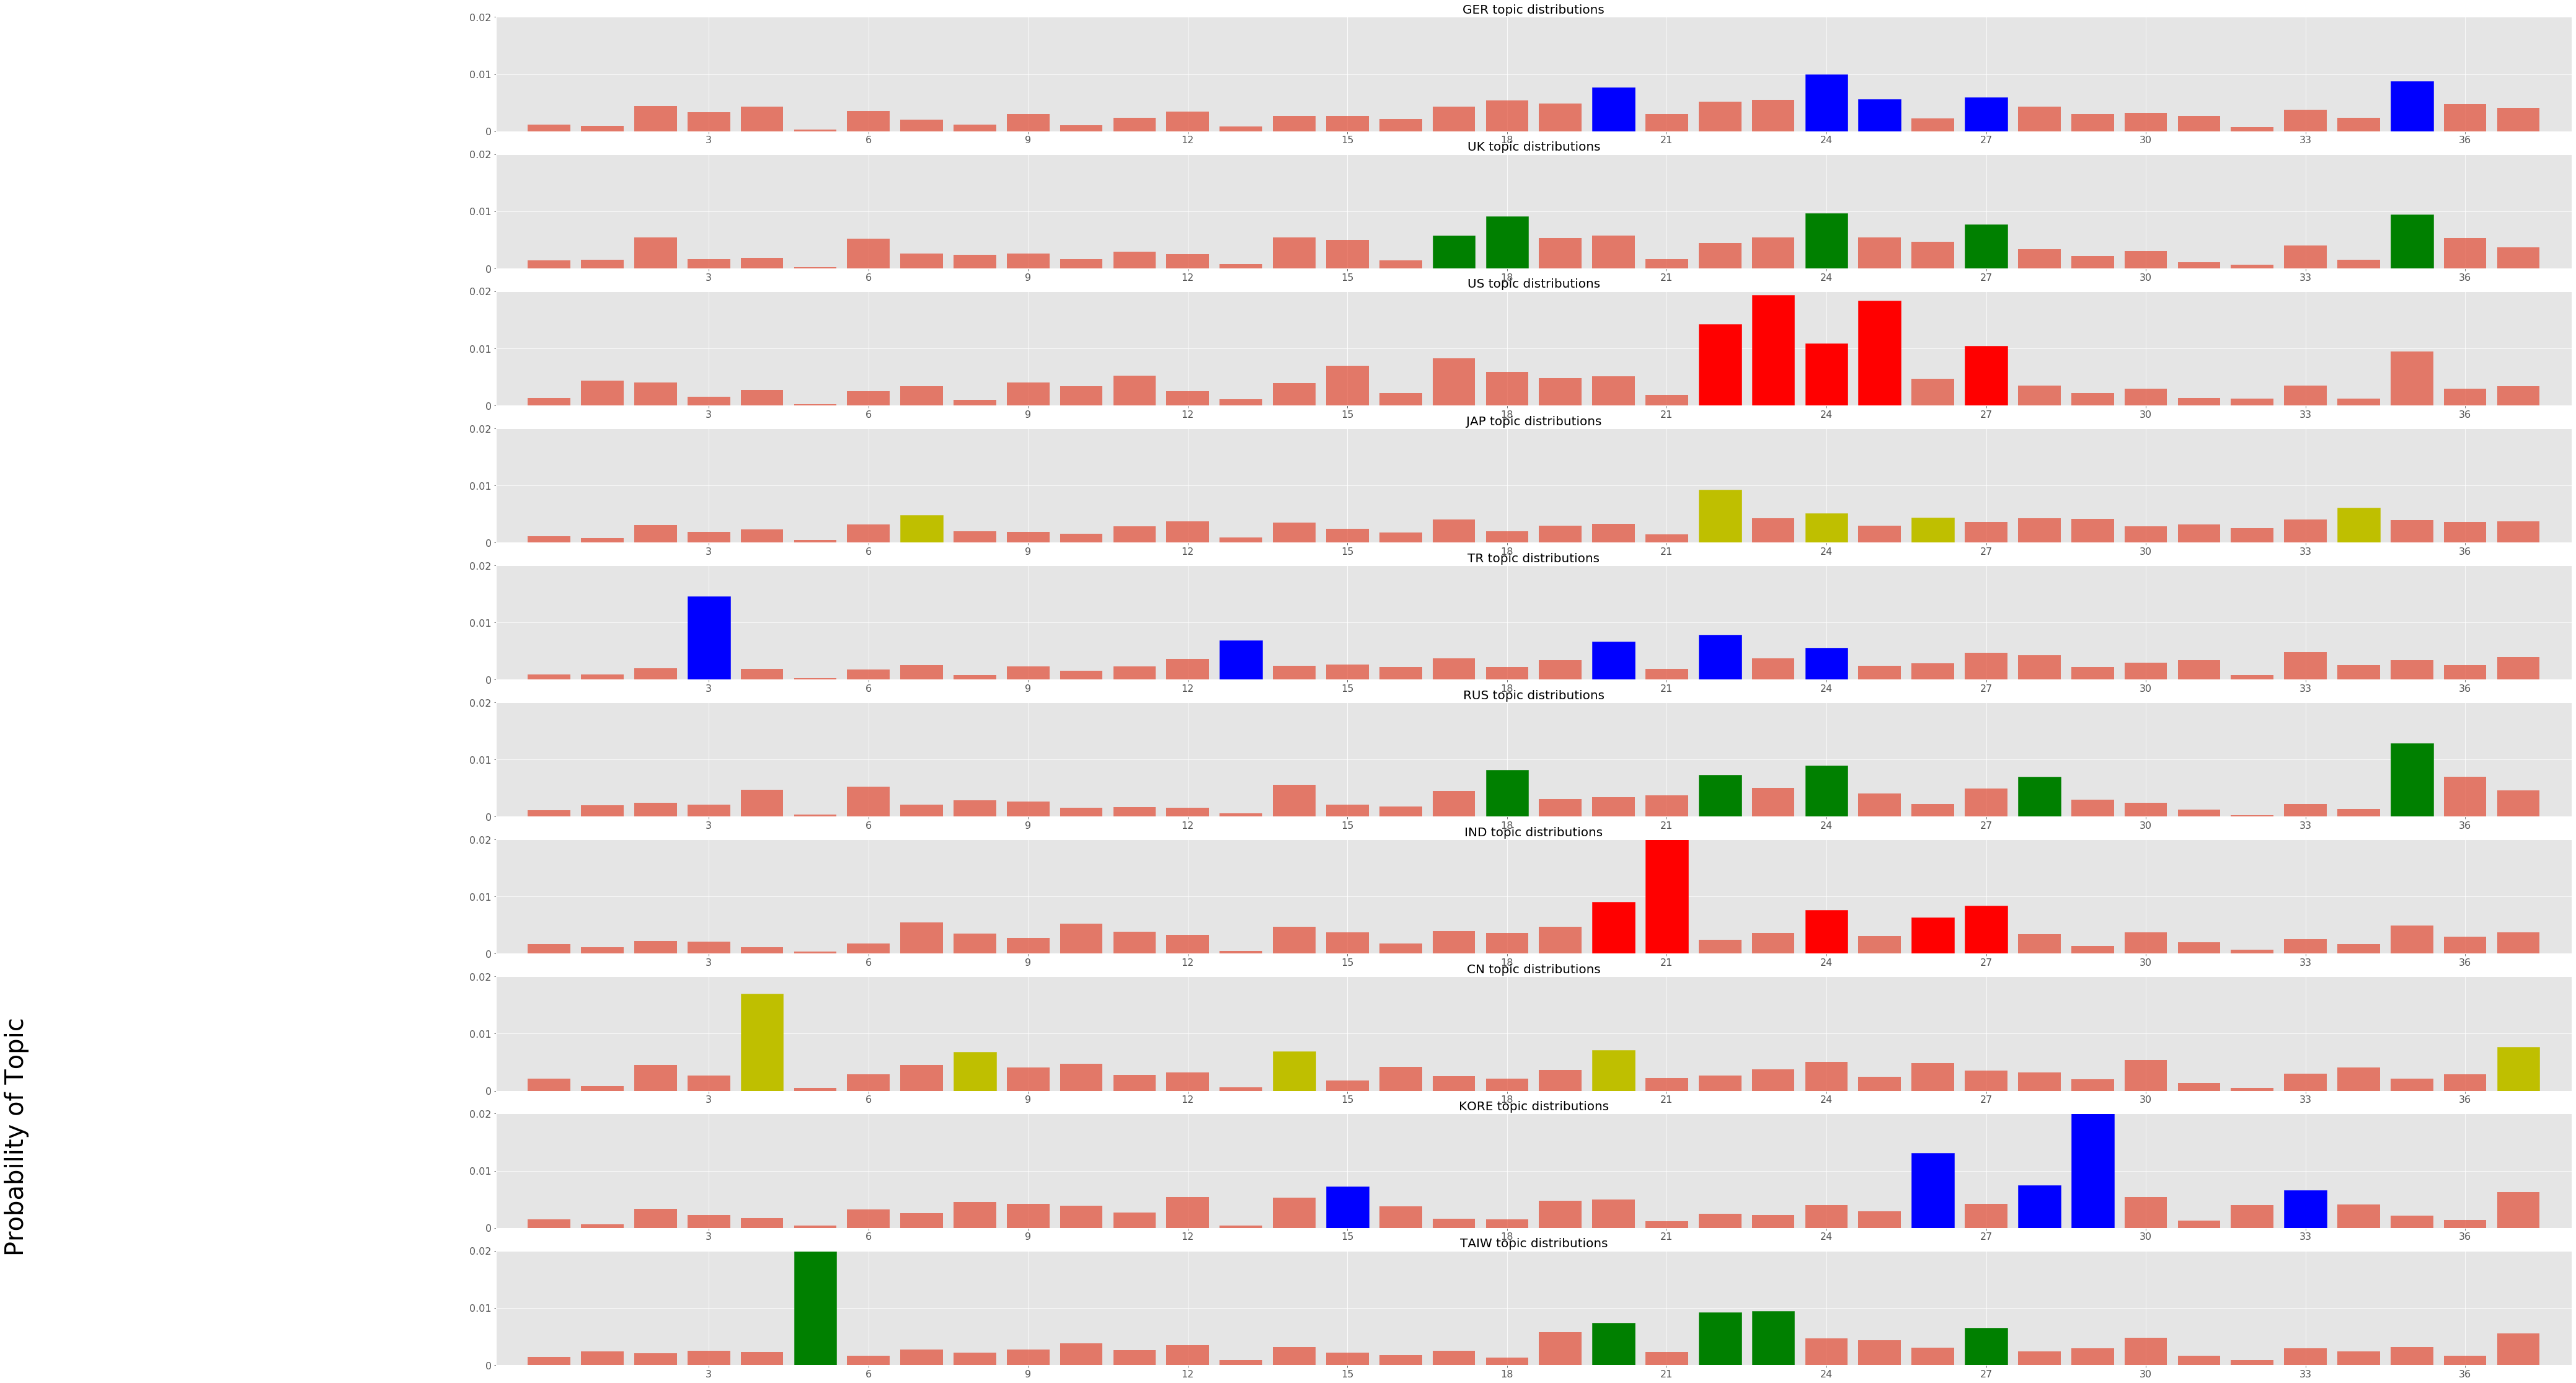

In [53]:
ntp=38
GER_topic_distribution = DTM[DTM.country == 'ger'].mean()
UK_topic_distribution = DTM[DTM.country == 'uk'].mean()
US_topic_distribution =DTM[DTM.country == 'us'].mean()
JAP_topic_distribution = DTM[DTM.country == 'jap'].mean()
TR_topic_distribution = DTM[DTM.country == 'tr'].mean()
RUS_topic_distribution = DTM[DTM.country == 'rus'].mean()
IND_topic_distribution =DTM[DTM.country == 'ind'].mean()
CN_topic_distribution = DTM[DTM.country == 'cn'].mean()
KORE_topic_distribution = DTM[DTM.country == 'kore'].mean()
TAIW_topic_distribution = DTM[DTM.country == 'taiw'].mean()

fig, [ax1,ax2,ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10] = plt.subplots(10,1,figsize=(60,40))

nr_top_bars = 5

ax1.set_title("GER topic distributions", fontsize=20)
ax2.set_title("UK topic distributions", fontsize=20)
ax3.set_title("US topic distributions", fontsize=20)
ax4.set_title("JAP topic distributions", fontsize=20)
ax5.set_title("TR topic distributions", fontsize=20)
ax6.set_title("RUS topic distributions", fontsize=20)
ax7.set_title("IND topic distributions", fontsize=20)
ax8.set_title("CN topic distributions", fontsize=20)
ax9.set_title("KORE topic distributions", fontsize=20)
ax10.set_title("TAIW topic distributions", fontsize=20)


ax10.text(-10, 0.04, "Probability of Topic", fontsize=40, ha="center", va="center",
         rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10],
                                   [GER_topic_distribution,UK_topic_distribution,US_topic_distribution, JAP_topic_distribution,
                                   TR_topic_distribution,RUS_topic_distribution,IND_topic_distribution,CN_topic_distribution,
                                   KORE_topic_distribution, TAIW_topic_distribution],
                                   ['b','g','r', 'y','b','g','r', 'y', 'b','g' ]):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, ntp)
    ax.set_xticks(range(int(ntp/10),ntp,int(ntp/10)))
    ax.set_xticklabels(range(int(ntp/10),ntp,int(ntp/10)), fontsize=16)
    ax.set_ylim(0,0.02)
    ax.set_yticks([0,0.01,0.02])
    ax.set_yticklabels([0,0.01,0.02], fontsize=16)

fig.tight_layout(h_pad=3.);

In [54]:
'''
lms= [[i[0] for i in li] for li in yak_vector]#for example prnk
dictionary = Dictionary(documents=lms)
corpus = [dictionary.doc2bow(text) for text in lms]

tfidf = TfidfModel(corpus)
vectors = tfidf[corpus]
values = [[i[1] for i in li] for li in yak_vector]#for example prnk
wid =  [[i[0] for i in li] for li in vectors]#for example prnk
tfvec=[]
for i, j in zip(wid, values):
    tfvec.append(list(zip(i,j)))
A= gensim.matutils.corpus2csc(vectors)
nmf = NMF(n_components=20, solver="mu")
 
W = nmf.fit_transform(A)
 
H = nmf.components_

tfidf_feature_names = list(dictionary.token2id) 


def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)

'''

'\nlms= [[i[0] for i in li] for li in yak_vector]#for example prnk\ndictionary = Dictionary(documents=lms)\ncorpus = [dictionary.doc2bow(text) for text in lms]\n\ntfidf = TfidfModel(corpus)\nvectors = tfidf[corpus]\nvalues = [[i[1] for i in li] for li in yak_vector]#for example prnk\nwid =  [[i[0] for i in li] for li in vectors]#for example prnk\ntfvec=[]\nfor i, j in zip(wid, values):\n    tfvec.append(list(zip(i,j)))\nA= gensim.matutils.corpus2csc(vectors)\nnmf = NMF(n_components=20, solver="mu")\n \nW = nmf.fit_transform(A)\n \nH = nmf.components_\n\ntfidf_feature_names = list(dictionary.token2id) \n\n\ndef display_topics(model, feature_names, no_top_words):\n    for topic_idx, topic in enumerate(model.components_):\n        print ("Topic %d:" % (topic_idx))\n        print (" ".join([feature_names[i]\n                        for i in topic.argsort()[:-no_top_words - 1:-1]]))\n        \nno_top_words = 10\ndisplay_topics(nmf, tfidf_feature_names, no_top_words)\n\n'